In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

%load_ext autoreload
%autoreload 2

In [2]:
import os
import random


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import metrics

In [4]:
import networkx as nx
import mpld3
mpld3.enable_notebook()

In [5]:
from crawler import BFS_crawl, draw_graph, get_df
from helpers import async_cache_pages, urls_list, urls_path
from features import construct_text_df

In [6]:
from keys import GOOGLE_KEY, GOOGLE_CX
from googleapiclient.discovery import build

In [7]:
seed = 0
random.seed(seed)
np.random.seed(seed)

In [8]:
folder_train = ['train-0']
folder_test_easy = ['test-easy']
folder_test_hard = ['test-hard']

In [9]:
def balanced_classes(df):
    n_pos = sum(df.label == True)
    n_neg = sum(df.label == False)

    min_pos_neg = min(n_pos, n_neg)


    return pd.concat([
            df[df.label == False].sample(min_pos_neg, random_state=seed), 
            df[df.label == True].sample(min_pos_neg, random_state=seed)
    ])

In [10]:
def analyse_easy_hard(folder_train, folder_test_easy, folder_test_hard, download_pages=True):
    train_pos, train_neg = urls_list(folder_train)
    
    test_pos_easy, test_neg_easy = urls_list(folder_test_easy)
    test_pos_hard, test_neg_hard = urls_list(folder_test_hard)

    if download_pages:
        print("Downloading pages")
        async_cache_pages(train_pos + train_neg + test_pos_easy + test_neg_easy + test_pos_hard + test_neg_hard)
    
    print("Constructing text dataframes")
    train_df = construct_text_df(train_pos + train_neg, [True] * len(train_pos) + [False] * len(train_neg))
    test_easy_df = construct_text_df(test_pos_easy + test_neg_easy, [True] * len(test_pos_easy) + [False] * len(test_neg_easy))
    test_hard_df = construct_text_df(test_pos_hard + test_neg_hard, [True] * len(test_pos_hard) + [False] * len(test_neg_hard))

    train_df_balanced = balanced_classes(train_df)
   
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=seed, max_iter=1000)),
    ])

    print("Training the model")
    pipeline.fit(train_df_balanced.visible_text, train_df_balanced.label)

    print("Predictions on test sets")
    y_easy_pred = pipeline.predict(test_easy_df.visible_text)
    y_easy_test = test_easy_df.label
    
    y_hard_pred = pipeline.predict(test_hard_df.visible_text)
    y_hard_test = test_hard_df.label

    print("==Easy task==")
    print(metrics.classification_report(y_easy_test, y_easy_pred))
    print(metrics.confusion_matrix(y_easy_test, y_easy_pred))
    easy_accuracy = metrics.accuracy_score(y_easy_test, y_easy_pred)
    print("Accuracy: {}".format(easy_accuracy))

    print("==Hard task==")
    print(metrics.classification_report(y_hard_test, y_hard_pred))
    print(metrics.confusion_matrix(y_hard_test, y_hard_pred))
    hard_accuracy = metrics.accuracy_score(y_hard_test, y_hard_pred)
    print("Accuracy: {}".format(hard_accuracy))
    
    return pipeline, easy_accuracy, hard_accuracy


In [11]:
analyse_easy_hard(folder_train, folder_test_easy, folder_test_hard, download_pages=False)

Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.64      0.96      0.77        47
       True       0.93      0.51      0.66        51

avg / total       0.79      0.72      0.71        98

[[45  2]
 [25 26]]
Accuracy: 0.7244897959183674
==Hard task==
             precision    recall  f1-score   support

      False       0.56      0.73      0.63        44
       True       0.68      0.51      0.58        51

avg / total       0.63      0.61      0.61        95

[[32 12]
 [25 26

(Pipeline(memory=None,
      steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))]),
 0.72448979591836737,
 0.61052631578947369)

Initial idea: crawl a google webpage directly. Problem: many links not related to the query are followed. Use the Google CustomSearch API instead

In [12]:
class RootUrlIterator:
    def __init__(self, base, query_beginning, query_ends):
        self.query_index = 0
        self.base = base
        self.query_beginning = query_beginning 
        self.query_ends = query_ends
        
    def __next__(self):
        next_query_end = self.query_ends[self.query_index]
        self.query_index = (self.query_index + 1) % len(self.query_ends)
        
        return "{}{} {}".format(self.base, self.query_beginning, next_query_end)

In [13]:
possible_learning_fields = ["Mathematics", "Science", "Health", "Art", "Music", "Dance", 
                        "Leadership", "Algebra", "Life Science", "Social Studies", "Geography",
                        "Programming", "History", "Biology"]

root_iterator = RootUrlIterator("https://www.google.ch/search?q=", "Online Course", possible_learning_fields)


In [14]:
for i in range(15):
    print(next(root_iterator))

https://www.google.ch/search?q=Online Course Mathematics
https://www.google.ch/search?q=Online Course Science
https://www.google.ch/search?q=Online Course Health
https://www.google.ch/search?q=Online Course Art
https://www.google.ch/search?q=Online Course Music
https://www.google.ch/search?q=Online Course Dance
https://www.google.ch/search?q=Online Course Leadership
https://www.google.ch/search?q=Online Course Algebra
https://www.google.ch/search?q=Online Course Life Science
https://www.google.ch/search?q=Online Course Social Studies
https://www.google.ch/search?q=Online Course Geography
https://www.google.ch/search?q=Online Course Programming
https://www.google.ch/search?q=Online Course History
https://www.google.ch/search?q=Online Course Biology
https://www.google.ch/search?q=Online Course Mathematics


In [15]:
pipeline_initial, accuracy_initial_easy, accuracy_initial_hard = analyse_easy_hard(folder_train, folder_test_easy, folder_test_hard, download_pages=False)

Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.64      0.96      0.77        47
       True       0.93      0.51      0.66        51

avg / total       0.79      0.72      0.71        98

[[45  2]
 [25 26]]
Accuracy: 0.7244897959183674
==Hard task==
             precision    recall  f1-score   support

      False       0.56      0.73      0.63        44
       True       0.68      0.51      0.58        51

avg / total       0.63      0.61      0.61        95

[[32 12]
 [25 26

In [16]:
# USE GOOGLE API FOR SEARCH

In [17]:
google_service = build("customsearch", "v1",
            developerKey=GOOGLE_KEY)

In [18]:
def google_search_links(query):
    res = google_service.cse().list(
      q=query,
      cx=GOOGLE_CX,
    ).execute()
    links = [item['link'] for item in res['items']]

    return links

In [19]:
google_search_links('dogs')

['http://www.vetstreet.com/dogs/',
 'https://en.wikipedia.org/wiki/Dog',
 'https://www.youtube.com/watch?v=4OLJe8iMLg4',
 'http://www.akc.org/dog-breeds/',
 'https://www.youtube.com/watch?v=1H6qWm2IGZ8',
 'http://www.animalplanet.com/pets/dogs/',
 'http://www.datdog.com/',
 'https://twitter.com/hashtag/dogs?lang=en',
 'https://www.webmd.com/pets/dogs/default.htm',
 'http://www.cnn.com/2017/12/22/health/cancer-therapy-dog-study/index.html']

In [20]:
class LearningFieldIterator:
    def __init__(self, base, fields):
        self.index = 0
        self.base = base
        self.fields = fields
        
    def __next__(self):
        next_field = self.fields[self.index]
        self.index = (self.index + 1) % len(self.fields)
        
        return "{} {}".format(self.base, next_field)

In [21]:
field_iterator = LearningFieldIterator('Course', possible_learning_fields)

for i in range(15):
    print(next(field_iterator))

Course Mathematics
Course Science
Course Health
Course Art
Course Music
Course Dance
Course Leadership
Course Algebra
Course Life Science
Course Social Studies
Course Geography
Course Programming
Course History
Course Biology
Course Mathematics


In [41]:
initial_field = next(field_iterator)
field_top_links = google_search_links(initial_field)
random_top_links = np.random.choice(field_top_links, 5)

print("BFS on roots: {}".format(random_top_links), end="\n\n")


G_initial = BFS_crawl(random_top_links, 4, 3, save=False, pipeline=pipeline_initial)
nx.write_gpickle(G_initial, os.path.join('saved', 'graphs', 'G_initial.pickle'))

BFS on roots: ['http://www.sothebysinstitute.com/short-courses/'
 'https://www.artofliving.org/us-en/courses'
 'https://artofproblemsolving.com/school/catalog'
 'https://artofproblemsolving.com/school/catalog'
 'https://www.edx.org/course/subject/art-culture']

BFS started with params: 
Depth_limit: 4
Breadth_limit: 3.
Estimated time: 1215s
............................

Exception while parsing https://www.facebook.com/sharer/sharer.php?u={URL}
'NoneType' object has no attribute 'findAll'


..........................................

Exception while requesting mailto:a.chakravartti@sothebysinstitute.com
No connection adapters were found for 'mailto:a.chakravartti@sothebysinstitute.com'


..

Exception while requesting mailto:applicationsupport@sothebysinstitute.com
No connection adapters were found for 'mailto:applicationsupport@sothebysinstitute.com'


...........

Exception while parsing https://www.facebook.com/sharer/sharer.php?u={URL}
'NoneType' object has no attribute 'findAll'


..................................................................................................................

Exception while requesting mailto:?subject={TITLE}&body={BODY}%0D%0A%0D%0A{URL}
No connection adapters were found for 'mailto:?subject={TITLE}&body={BODY}%0D%0A%0D%0A{URL}'


.........

Exception while requesting mailto:?subject={TITLE}&body={BODY}%0D%0A%0D%0A{URL}
No connection adapters were found for 'mailto:?subject={TITLE}&body={BODY}%0D%0A%0D%0A{URL}'


..............

Exception while requesting mailto:?subject=MA Art Business%20in%20Los Angeles%20%7C%20Sotheby's%20Institute%20of%20Art%20&body=The art business program of Sotheby’s Institute of Art - Los Angeles brings together core values and a unique philosophy about leadership and management in the arts. All students entering the MA in Art Business program take a foundation semester of core management courses and are then free to choose from a wide range of concentrations tailored to specific areas in the creative industries. Learn more...%0D%0A%0D%0Ahttp://www.sothebysinstitute.com/los-angeles/masters-programs/ma-art-business
No connection adapters were found for 'mailto:?subject=MA Art Business%20in%20Los Angeles%20%7C%20Sotheby's%20Institute%20of%20Art%20&body=The art business program of Sotheby’s Institute of Art - Los Angeles brings together core values and a unique philosophy about leadership and management in the arts. All students entering the MA in Art Business program take a foundation se

..............................................................................................................................................................................................................................................................Crawling finished after 762.6274416446686s


FALSE: -0.19289796743025941 www.sothebysinstitute.com/news-and-events/events/
FALSE: -0.29718808338278185 www.sothebysinstitute.com/contact
FALSE: -0.25562795551783524 www.artofliving.org/us-en/node/462183
FALSE: -0.31504714394744393 www.timeanddate.com/worldclock/fixedtime.html?iso=20170829T1930&p1=179&ah=1&am=30
TRUE: 0.6149794214150934 artofproblemsolving.com/school/course/python2
FALSE: -0.39936519373621265 www.artofliving.org/us-en/srisriontour
TRUE: 0.21678443782806406 artofproblemsolving.com/school/course/maa-amc12#amc-12
FALSE: -0.4410350138832183 artofproblemsolving.com/community
FALSE: -0.37230930233927656 artofproblemsolving.com/contact
FALSE: -0.15211015764374347 artofproblemsolving.com/user/register.php
FALSE: -0.2534235947829898 www.artofliving.org/us-en/node/8757
FALSE: -0.21571597648377136 artofproblemsolving.com/store/item/moems-olympiad3
FALSE: -0.44652008113106423 www.timeanddate.com/topics/
FALSE: -0.0638829920517125 www.qaa.ac.uk/faqs
TRUE: 0.22875908565577202 arto

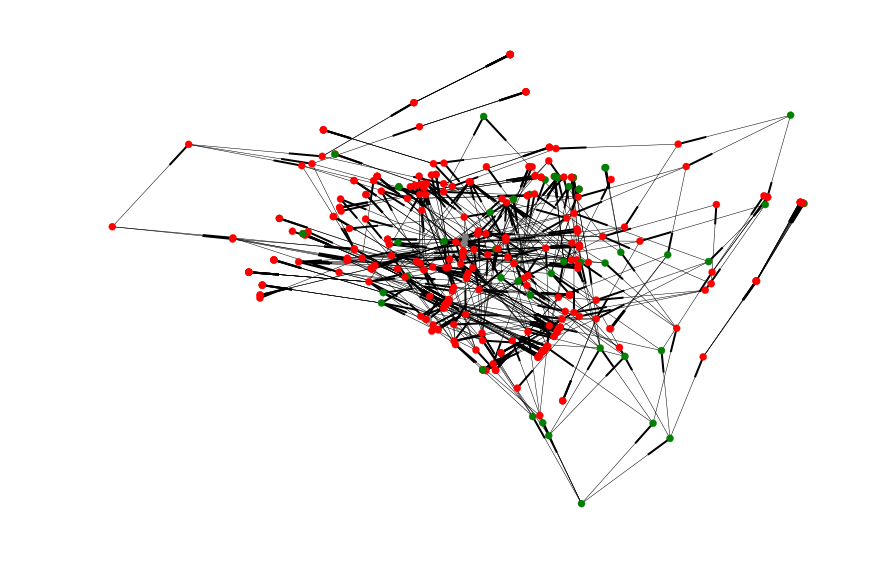

In [42]:
draw_graph(G_initial, plt, print_pos=True, print_neg=True)

In [43]:
df = get_df(G_initial)
excel_save_path = os.path.join("webpages", "experiment1", "bfs_results")

df['user_verdict'] = "TODO"
df = df.sort_values(by="decision_func")

# Save df to excel
df.to_excel(os.path.join(excel_save_path, "run_0.xlsx"))

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'mailto:?subject=MA Art Business%20in%20Los Angeles%20%7C%20Sotheby's%20Institute%20of%20Art%20&body=The art business program of Sotheby’s Institute of Art - Los Angeles brings together core values and a unique philosophy about leadership and management in the arts. All students entering the MA in Art Business program take a foundation semester of core management courses and are then free to choose from a wide range of concentrations tailored to specific areas in the creative industries. Learn more...%0D%0A%0D%0Ahttp://www.sothebysinstitute.com/los-angeles/masters-programs/ma-art-business' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))


User needs to fill his verdict in the 'user_verdict' column:
* Try to give verdict for the most ambiguous webpages (decision_func =~ 0.0)
* PASS when the page cannot be determined, or cannot be downloaded automatically (f.i. udemy or edx)
* FALSE when the webpage is not a course page
* TRUE when the webpage is a course page

In [44]:
df_verdict = pd.read_excel(os.path.join(excel_save_path, "run_0_verdict.xlsx"))

In [45]:
true_negatives = sum((df_verdict.status == 'class_false') & (df_verdict.user_verdict == False))
true_positives = sum((df_verdict.status == 'class_true') & (df_verdict.user_verdict == True))
false_negatives = sum((df_verdict.status == 'class_false') & (df_verdict.user_verdict == True))
false_positives = sum((df_verdict.status == 'class_true') & (df_verdict.user_verdict == False))
failures = sum((df_verdict.status == 'req_failed') | (df_verdict.user_verdict == "PASS") | (df_verdict.user_verdict == "TODO"))

In [46]:
true_negatives, true_positives, false_negatives, false_positives, failures

(17, 12, 0, 15, 305)

Entries were specifically chosen if they were wrong, so it is good to have a big amount of false negatives / false positives

In [48]:
print('''==User verdict report==
True negatives: {}
True positives: {}
False negatives: {}
False positives: {}
Failures / not done: {}
'''.format(true_negatives, true_positives, false_negatives, false_positives, failures))

==User verdict report==
True negatives: 17
True positives: 12
False negatives: 0
False positives: 15
Failures / not done: 305



In [49]:
# Balance classes to avoid overflowing training set with negative examples
n_pos = sum(df_verdict.user_verdict == True)
n_neg = sum(df_verdict.user_verdict == False)

min_pos_neg = min(n_pos, n_neg)


df_verdict = pd.concat([
        df_verdict[df_verdict.user_verdict == False].sample(min_pos_neg, random_state=seed), 
        df_verdict[df_verdict.user_verdict == True].sample(min_pos_neg, random_state=seed)
])

In [50]:
pos_path = urls_path("train-1", positive=True)
neg_path = urls_path("train-1", positive=False)

# Write positives to file
with open(pos_path, 'w') as pos_file:
    for url in df_verdict[df_verdict.user_verdict == True].url:
        pos_file.write(url + '\n')
        
# Write negatives to file
with open(neg_path, 'w') as neg_file:
    for url in df_verdict[df_verdict.user_verdict == False].url:
        neg_file.write(url + '\n')

In [51]:
def BFS_on_next_fields(pipeline, field_iterator):
    next_field = next(field_iterator)
    field_top_links = google_search_links(next_field)
    random_top_links = np.random.choice(field_top_links, 5)

    print("BFS on roots: {}".format(random_top_links), end="\n\n")


    G = BFS_crawl(random_top_links, 5, 3, save=False, pipeline=pipeline)
    
    return G

In [52]:
def generate_user_submission(G, run_number):
    df = get_df(G)
    excel_save_path = os.path.join("webpages", "experiment1", "bfs_results")

    df['user_verdict'] = "TODO"
    df = df.sort_values(by="decision_func")

    # Save df to excel
    df.to_excel(os.path.join(excel_save_path, "run_{}.xlsx".format(run_number)))

In [53]:
def read_user_verdict(run_number):
    return pd.read_excel(os.path.join(excel_save_path, "run_{}_verdict.xlsx".format(run_number)))

In [54]:
def user_verdict_report(df_verdict):
    true_negatives = sum((df_verdict.status == 'class_false') & (df_verdict.user_verdict == False))
    true_positives = sum((df_verdict.status == 'class_true') & (df_verdict.user_verdict == True))
    false_negatives = sum((df_verdict.status == 'class_false') & (df_verdict.user_verdict == True))
    false_positives = sum((df_verdict.status == 'class_true') & (df_verdict.user_verdict == False))
    failures = sum((df_verdict.status == 'req_failed') | (df_verdict.user_verdict == "PASS") | (df_verdict.user_verdict == "TODO"))
    
    print('''==User verdict report==
    True negatives: {}
    True positives: {}
    False negatives: {}
    False positives: {}
    Failures / not done: {}
    '''.format(true_negatives, true_positives, false_negatives, false_positives, failures))

In [55]:
def save_verdict_to_training(df_verdict, run_num):
    # Balance classes to avoid overflowing training set with negative examples
    n_pos = sum(df_verdict.user_verdict == True)
    n_neg = sum(df_verdict.user_verdict == False)

    min_pos_neg = min(n_pos, n_neg)


    df_verdict = pd.concat([
            df_verdict[df_verdict.user_verdict == False].sample(min_pos_neg, random_state=seed), 
            df_verdict[df_verdict.user_verdict == True].sample(min_pos_neg, random_state=seed)
    ])
    
    
    # Generate write paths
    train_folder = "train-{}".format(run_num)
    pos_path = urls_path(train_folder, positive=True)
    neg_path = urls_path(train_folder, positive=False)

    # Write positives to file
    with open(pos_path, 'w') as pos_file:
        for url in df_verdict[df_verdict.user_verdict == True].url:
            pos_file.write(url + '\n')

    # Write negatives to file
    with open(neg_path, 'w') as neg_file:
        for url in df_verdict[df_verdict.user_verdict == False].url:
            neg_file.write(url + '\n')

In [56]:
pipeline_1, accuracy_1_easy, accuracy_1_hard = analyse_easy_hard(['train-0', 'train-1'], folder_test_easy, folder_test_hard, download_pages=True)

Error while downloading: https://www.economist.com/digital. Status code: 403
Error while downloading: http://blog.openclassrooms.com/en/. Status code: 403
Trying again to download 0 pages one at a time
Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.65      0.98      0.78        47
       True       0.96      0.51      0.67        51

avg / total       0.81      0.73      0.72        98

[[46  1]
 [25 26]]
Accuracy: 0.7346938775510204
==Hard task==
             precision    rec

In [57]:
G_2 = BFS_on_next_fields(pipeline_1, field_iterator)
nx.write_gpickle(G_2, os.path.join('saved', 'graphs', 'G_2.pickle'))

BFS on roots: ['https://online.berklee.edu/courses'
 'https://www.academiccourses.com/Courses/Music/'
 'https://www.academiccourses.com/Courses/Music/'
 'https://www.udemy.com/courses/music/production/'
 'https://www.coursera.org/courses?languages=en&query=music']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
..................................................................

Exception while requesting mailto:transfer@online.berklee.edu
No connection adapters were found for 'mailto:transfer@online.berklee.edu'


..................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


...

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


..............................................................................

Exception while requesting mailto:graduation@online.berklee.edu
No connection adapters were found for 'mailto:graduation@online.berklee.edu'


................................

Exception while requesting mailto: advisors@online.berklee.edu
No connection adapters were found for 'mailto: advisors@online.berklee.edu'


.....

Exception while requesting mailto:graduation@online.berklee.edu
No connection adapters were found for 'mailto:graduation@online.berklee.edu'


................................

Exception while requesting https://www.google.com/settings/ads/onweb/?hl=en&sig=ACi0TCg5xW6Mv2Tu6S4k3GhqJV5Z7QgjIDB8VMM0TNzE3P0Ui36lBa_y8Ev7wsb8klKG5jtHnSa8RRvd_hyzzse0husVjWfAKe8GZNP-BQqqFimIb1eNzgmgh9J_XIqrT6ZZBnVxdRPQmLsyk1jmcRO46P8JwRdNctaN2301ZwS9zevJT0suEoEJB0e9kvrxllKmQmNE9BO3
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.google.com,settings,ads,onweb,?hl=en&sig=ACi0TCg5xW6Mv2Tu6S4k3GhqJV5Z7QgjIDB8VMM0TNzE3P0Ui36lBa_y8Ev7wsb8klKG5jtHnSa8RRvd_hyzzse0husVjWfAKe8GZNP-BQqqFimIb1eNzgmgh9J_XIqrT6ZZBnVxdRPQmLsyk1jmcRO46P8JwRdNctaN2301ZwS9zevJT0suEoEJB0e9kvrxllKmQmNE9BO3'


.........................................

Exception while requesting https://www.google.com/settings/ads/onweb/?hl=en&sig=ACi0TCg5xW6Mv2Tu6S4k3GhqJV5Z7QgjIDB8VMM0TNzE3P0Ui36lBa_y8Ev7wsb8klKG5jtHnSa8RRvd_hyzzse0husVjWfAKe8GZNP-BQqqFimIb1eNzgmgh9J_XIqrT6ZZBnVxdRPQmLsyk1jmcRO46P8JwRdNctaN2301ZwS9zevJT0suEoEJB0e9kvrxllKmQmNE9BO3
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.google.com,settings,ads,onweb,?hl=en&sig=ACi0TCg5xW6Mv2Tu6S4k3GhqJV5Z7QgjIDB8VMM0TNzE3P0Ui36lBa_y8Ev7wsb8klKG5jtHnSa8RRvd_hyzzse0husVjWfAKe8GZNP-BQqqFimIb1eNzgmgh9J_XIqrT6ZZBnVxdRPQmLsyk1jmcRO46P8JwRdNctaN2301ZwS9zevJT0suEoEJB0e9kvrxllKmQmNE9BO3'


......................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2gS8RT7&h=ATN2DRj11c_u22MrnaPpGBBLG3bGvV0gBOBsf7O7puI7T74l-KFO530yPJ0AsvipfE1Whp-WUdcFhfbKmqFQ4sxi5llGqZ9VlQtpXvhGz0m05KfOTwfNuktXC1yMMX89hQ6qOSF4tttrsAUeu6Gfk4bfJvZuOEPaAjxjTWfUnHJeZUQLsPejMPERZAllhCfyFSZkNVx-doFgpWanHU88rMkmUPI_AHNdVZWjWTpdsiKf25UGX-PUIE7-KgSspKSpQhG4oCD3wMKgWW4Db3MYibAmyA
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2gS8RT7&h=ATN2DRj11c_u22MrnaPpGBBLG3bGvV0gBOBsf7O7puI7T74l-KFO530yPJ0AsvipfE1Whp-WUdcFhfbKmqFQ4sxi5llGqZ9VlQtpXvhGz0m05KfOTwfNuktXC1yMMX89hQ6qOSF4tttrsAUeu6Gfk4bfJvZuOEPaAjxjTWfUnHJeZUQLsPejMPERZAllhCfyFSZkNVx-doFgpWanHU88rMkmUPI_AHNdVZWjWTpdsiKf25UGX-PUIE7-KgSspKSpQhG4oCD3wMKgWW4Db3MYibAmyA'


...........................................................................................................

Exception while requesting http://www.linkedin.com/shareArticle?mini=true&title=What%27s%20Your%20Coursera%20Story%3F&url=https://blog.coursera.org/whats-coursera-story/&summary=Has+taking+a+course+on+Coursera+impacted+your+life+in+any+way%2C+big+or+small%3F+Whether+learning+helped...
[Errno 36] File name too long: 'webpages/experiment1/cache/http:,,www.linkedin.com,shareArticle?mini=true&title=What%27s%20Your%20Coursera%20Story%3F&url=https:,,blog.coursera.org,whats-coursera-story,&summary=Has+taking+a+course+on+Coursera+impacted+your+life+in+any+way%2C+big+or+small%3F+Whether+learning+helped...'


............

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


.........................................................................................................................

Exception while requesting mailto:advisors@online.berklee.edu
No connection adapters were found for 'mailto:advisors@online.berklee.edu'


............................................

Exception while requesting mailto:advisors@online.berklee.edu
No connection adapters were found for 'mailto:advisors@online.berklee.edu'


............

Exception while requesting http://us.music-jobs.com 
HTTPConnectionPool(host='us.music-jobs.com%20', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb107cff4e0>: Failed to establish a new connection: [Errno -2] Name or service not known',))


..................

Exception while requesting mailto:degreecompletion@online.berklee.edu
No connection adapters were found for 'mailto:degreecompletion@online.berklee.edu'


..........

Exception while requesting https://online.berklee.edu/takenote/2017/11/
HTTPSConnectionPool(host='online.berklee.edu', port=443): Max retries exceeded with url: /takenote/2017/11/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fb0f2955550>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))


..

Exception while requesting mailto:advisors@online.berklee.edu
No connection adapters were found for 'mailto:advisors@online.berklee.edu'


.................

Exception while requesting mailto:transfercredits@berklee.edu
No connection adapters were found for 'mailto:transfercredits@berklee.edu'


.....

Exception while requesting mailto:advisors@online.berklee.edu
No connection adapters were found for 'mailto:advisors@online.berklee.edu'


................................................

Exception while requesting mailto:support@masterstudies.com,fabien@masterstudies.com
No connection adapters were found for 'mailto:support@masterstudies.com,fabien@masterstudies.com'


.........................................................................................................................

Exception while requesting mailto:support@masterstudies.com,fabien@masterstudies.com
No connection adapters were found for 'mailto:support@masterstudies.com,fabien@masterstudies.com'


............................................................................................................................................................................................................................................................................................................................

Exception while requesting mailto:info@perimeterx.com
No connection adapters were found for 'mailto:info@perimeterx.com'


.......................

Exception while requesting mailto:info@perimeterx.com
No connection adapters were found for 'mailto:info@perimeterx.com'


.................................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


.............

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


..............................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATO-IyWYeiryXBRF8S_PAdLxAz08G6KaNEpjGc3gcnZpOVUWlRzwekWxzP42yt63DBliptgvpVLhoywxDEHy6kMPAN3ib5MWBlhR_YirUsEV7vw5eyMhA8IArFq4wEmwc6tVj0Rm0A2neHUegTDcXlFapXQWwK8uCPpwZfrAwMnCjn7RR6nU3rg37FXwRc23CVoRry5u1KmIybiJFyu88O6f7NxGELEDfaVyzIm9ppIKKq0V0xfJrnJE5bD08OV9v6DhX8IZQQnrH4rGDOnf6rnk3Fo
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATO-IyWYeiryXBRF8S_PAdLxAz08G6KaNEpjGc3gcnZpOVUWlRzwekWxzP42yt63DBliptgvpVLhoywxDEHy6kMPAN3ib5MWBlhR_YirUsEV7vw5eyMhA8IArFq4wEmwc6tVj0Rm0A2neHUegTDcXlFapXQWwK8uCPpwZfrAwMnCjn7RR6nU3rg37FXwRc23CVoRry5u1KmIybiJFyu88O6f7NxGELEDfaVyzIm9ppIKKq0V0xfJrnJE5bD08OV9v6DhX8IZQQnrH4rGDOnf6rnk3Fo'


.........

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


...................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


....................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


.

Exception while requesting mailto:press@coursera.org
No connection adapters were found for 'mailto:press@coursera.org'


...............................................................Crawling finished after 1853.076221704483s


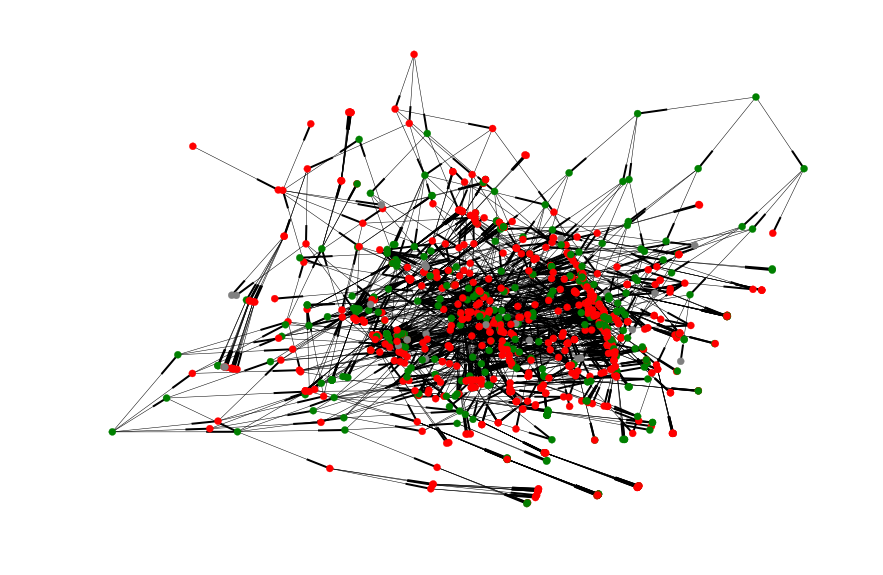

In [60]:
draw_graph(G_2, plt, print_pos=False, print_neg=False)

In [61]:
generate_user_submission(G_2, 2)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://www.google.com/settings/ads/onweb/?hl=en&sig=ACi0TCg5xW6Mv2Tu6S4k3GhqJV5Z7QgjIDB8VMM0TNzE3P0Ui36lBa_y8Ev7wsb8klKG5jtHnSa8RRvd_hyzzse0husVjWfAKe8GZNP-BQqqFimIb1eNzgmgh9J_XIqrT6ZZBnVxdRPQmLsyk1jmcRO46P8JwRdNctaN2301ZwS9zevJT0suEoEJB0e9kvrxllKmQmNE9BO3' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATO-IyWYeiryXBRF8S_PAdLxAz08G6KaNEpjGc3gcnZpOVUWlRzwekWxzP42yt63DBliptgvpVLhoywxDEHy6kMPAN3ib5MWBlhR_YirUsEV7vw5eyMhA8IArFq4wEmwc6tVj0Rm0A2neHUegTDcXlFapXQWwK8uCPpwZfrAwMnCjn7RR6nU3rg37FXwRc23CVoRry5u1KmIybiJFyu88O6f7NxGELEDfaVyzIm9ppIKKq0V0xfJrnJE5bD08OV9v6DhX8IZQQnrH4rGDOnf6rnk3Fo' with link or location/anchor > 255 characters since it exceeds Excel's limit 

**Here user fills his verdict...**

In [62]:
df_verdict = read_user_verdict(2)
user_verdict_report(df_verdict)
save_verdict_to_training(df_verdict, 2)

==User verdict report==
    True negatives: 7
    True positives: 14
    False negatives: 0
    False positives: 16
    Failures / not done: 1007
    


In [63]:
previous_train_folders = ['train-0', 'train-1', 'train-2']
pipeline_2, accuracy_2_easy, accuracy_2_hard = analyse_easy_hard(previous_train_folders, folder_test_easy, folder_test_hard, download_pages=True)

Error while downloading: http://blog.openclassrooms.com/en/. Status code: 403
Error while downloading: https://www.economist.com/digital. Status code: 403
Trying again to download 0 pages one at a time
Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.65      0.96      0.78        47
       True       0.93      0.53      0.67        51

avg / total       0.80      0.73      0.72        98

[[45  2]
 [24 27]]
Accuracy: 0.7346938775510204
==Hard task==
             precision    rec

In [69]:
G_3 = BFS_on_next_fields(pipeline_2, field_iterator)

BFS on roots: ['https://dance.gmu.edu/academics/dance-courses'
 'https://catalog.ua.edu/undergraduate/arts-sciences/theatre-dance/courses/'
 'https://cla.purdue.edu/vpa/dance/courses/index.html'
 'https://catalog.ua.edu/undergraduate/arts-sciences/theatre-dance/courses/'
 'https://www.swarthmore.edu/dance-program/courses']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
................................

Exception while requesting http://www.as.ua.edu/
HTTPConnectionPool(host='www.as.ua.edu', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb107878d30>: Failed to establish a new connection: [Errno 110] Connection timed out',))


.................................................................

Exception while requesting mailto:itsd@ua.edu
No connection adapters were found for 'mailto:itsd@ua.edu'


......

Exception while requesting mailto:itsd@ua.edu
No connection adapters were found for 'mailto:itsd@ua.edu'


........................

Exception while requesting https://directory.purdue.edu/perl/nph-update.pl
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


.................

Exception while requesting mailto:itsd@ua.edu
No connection adapters were found for 'mailto:itsd@ua.edu'


....

Exception while requesting http://museums.ua.edu/
HTTPConnectionPool(host='museums.ua.edu', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0f306d4a8>: Failed to establish a new connection: [Errno 110] Connection timed out',))


.....

Exception while requesting javascript:loadLocale('en_US_mod');
No connection adapters were found for 'javascript:loadLocale('en_US_mod');'


.

Exception while requesting Javascript:showCopyrightDetail()
No connection adapters were found for 'Javascript:showCopyrightDetail()'


............................

Exception while requesting javascript:closeLayer('divlayer3');
No connection adapters were found for 'javascript:closeLayer('divlayer3');'


.

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


................................................................

Exception while requesting mailto:cdambois@gmu.edu
No connection adapters were found for 'mailto:cdambois@gmu.edu'


....................................

Exception while requesting mailto:ineice@ua.edu
No connection adapters were found for 'mailto:ineice@ua.edu'


.....................................

Exception while requesting http://museums.ua.edu/
HTTPConnectionPool(host='museums.ua.edu', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0f31cac50>: Failed to establish a new connection: [Errno 110] Connection timed out',))


........

Exception while parsing http://www.linkedin.com/profinder?trk=hb_ft_profinder
'NoneType' object has no attribute 'findAll'


..........

Exception while requesting https://wl.mypurdue.purdue.edu
('Connection aborted.', OSError("(104, 'ECONNRESET')",))


.................

Exception while parsing https://www.linkedin.com/edu/purdue-university-18357
'NoneType' object has no attribute 'findAll'


.

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fcla.purdue.edu%2Fthink%2F&h=ATMAr__FfjqFjUV650CKFK6IKZZR20itmgSM770LoZh3YNTQlmjV-IdqMfK7dmy10NLv6NhIgqzwuo-yurD_4hL3g0YHu3yMIXNiDt0fPVvonT51oU4GPIbODHYAa2nFwA_WgOrGqybTxf9agj6WESFOhbgSfWp9mlMoPyulNRYCRbRHsoFER8y7-PXf3iXChcUDqgDeNhbjyl45Qbkdps6sBlkC2QmYx5IerkQPLLli0275JR3g70VmV-CxwnNMGUUe3OCoj-4F7m5hTxkdEGr9pmYrcLvsDdNCkyCU8AEaSy6KHDG2is4Ab8f3Oh4fTwzEwQ
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fcla.purdue.edu%2Fthink%2F&h=ATMAr__FfjqFjUV650CKFK6IKZZR20itmgSM770LoZh3YNTQlmjV-IdqMfK7dmy10NLv6NhIgqzwuo-yurD_4hL3g0YHu3yMIXNiDt0fPVvonT51oU4GPIbODHYAa2nFwA_WgOrGqybTxf9agj6WESFOhbgSfWp9mlMoPyulNRYCRbRHsoFER8y7-PXf3iXChcUDqgDeNhbjyl45Qbkdps6sBlkC2QmYx5IerkQPLLli0275JR3g70VmV-CxwnNMGUUe3OCoj-4F7m5hTxkdEGr9pmYrcLvsDdNCkyCU8AEaSy6KHDG2is4Ab8f3Oh4fTwzEwQ'


............

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fapps.npr.org%2Fbest-books-2017%2F%23%2Ftag%2Fpoetry&h=ATPbtmQc1b1Imtd8Vgp6oOCA-KvQ44cNGKeNFzMH31zwiBTvdHFSo7WLBU9RNNxoxo-2daOJSYLPclHUMjGcDLdSo-IcCohTJarAOn7yV0wfjbwWCfW98_UHaUPXG9scbR3V6AGJvcx5ZLSL-4h7MHxeuX0BL8CqyrchqKnkibDyJtF5wYdHa6_vFrmXKb9LobcyMQ1YgZ2vxgEW69C1rbM7YaPXQF74k_HSfcDAfy7qTueXUQk2NGnt0oh3-VBHeqFfgXVZj-28PdN1co_qdUTH0W_1BkA
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fapps.npr.org%2Fbest-books-2017%2F%23%2Ftag%2Fpoetry&h=ATPbtmQc1b1Imtd8Vgp6oOCA-KvQ44cNGKeNFzMH31zwiBTvdHFSo7WLBU9RNNxoxo-2daOJSYLPclHUMjGcDLdSo-IcCohTJarAOn7yV0wfjbwWCfW98_UHaUPXG9scbR3V6AGJvcx5ZLSL-4h7MHxeuX0BL8CqyrchqKnkibDyJtF5wYdHa6_vFrmXKb9LobcyMQ1YgZ2vxgEW69C1rbM7YaPXQF74k_HSfcDAfy7qTueXUQk2NGnt0oh3-VBHeqFfgXVZj-28PdN1co_qdUTH0W_1BkA'


.........................................

Exception while requesting http://www.law.ua.edu/admissions/
HTTPConnectionPool(host='www.law.ua.edu', port=80): Max retries exceeded with url: /admissions/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb1079008d0>: Failed to establish a new connection: [Errno 110] Connection timed out',))


.....................................................................

Exception while requesting javascript:selectNone('2');
No connection adapters were found for 'javascript:selectNone('2');'


.

Exception while requesting javascript:selectAll('4');
No connection adapters were found for 'javascript:selectAll('4');'


............................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BuOl43&h=ATP11e2EfWcWX7DcaG2sdXdCXUd1X2HxmbFZ6eBGGZKJnmVEemBZENLyUGXRFDKhViU0S11PivqbODXTYkMk7mrp9_O3grOWiCwiyI1AmKIfo0fRk0b-P9Ws2I9PZj1y1VzQKatF29l5RuNaH-8r-nUi_FPu_NjKGKumU2W32yAkj8xLMEsQ3CKaXn2kWI7rvXr4ApkKykFiQomA8Ean4RDp1p2b4CIiudXZltVKBNkfY2u2HA_bma-NZ-GIAPTTPSf5TVqu83Bo4uBgnLVjvf8g
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2BuOl43&h=ATP11e2EfWcWX7DcaG2sdXdCXUd1X2HxmbFZ6eBGGZKJnmVEemBZENLyUGXRFDKhViU0S11PivqbODXTYkMk7mrp9_O3grOWiCwiyI1AmKIfo0fRk0b-P9Ws2I9PZj1y1VzQKatF29l5RuNaH-8r-nUi_FPu_NjKGKumU2W32yAkj8xLMEsQ3CKaXn2kWI7rvXr4ApkKykFiQomA8Ean4RDp1p2b4CIiudXZltVKBNkfY2u2HA_bma-NZ-GIAPTTPSf5TVqu83Bo4uBgnLVjvf8g'


.

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.articulateshow.org%2Farticulate%2Fkyle-abraham-a-life-in-motion&h=ATOHd_8r6hhHHsDow5qwp0htfK_flfHQtJ_q7wctC0vIsT8DYo3EIFAg2_-1bz7YgPvaFsmfpsjFgByS5WOJvRjjpDjRGPiAsgUWai7IiUgmwPWICWe0xFWPgXIsXjefTGNjR0H3olWu2pdWHhMWVk-bW2XN5HiztpALYQsrxar2Oh_9bdxHXt_FS1ZsEhyF4F3xtyiVPdl5L0nX-NA6CyQRyr1JvJff4DOxPpvQQYmcoVEiGOgGhxz5FJudHzxOiZa3hon6k1HHOaftI1oPn5jc
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.articulateshow.org%2Farticulate%2Fkyle-abraham-a-life-in-motion&h=ATOHd_8r6hhHHsDow5qwp0htfK_flfHQtJ_q7wctC0vIsT8DYo3EIFAg2_-1bz7YgPvaFsmfpsjFgByS5WOJvRjjpDjRGPiAsgUWai7IiUgmwPWICWe0xFWPgXIsXjefTGNjR0H3olWu2pdWHhMWVk-bW2XN5HiztpALYQsrxar2Oh_9bdxHXt_FS1ZsEhyF4F3xtyiVPdl5L0nX-NA6CyQRyr1JvJff4DOxPpvQQYmcoVEiGOgGhxz5FJudHzxOiZa3hon6k1HHOaftI1oPn5jc'


..........................................................................

Exception while requesting mailto:cbuchann@gmu.edu
No connection adapters were found for 'mailto:cbuchann@gmu.edu'


..............

Exception while requesting mailto:kharrism@gmu.edu
No connection adapters were found for 'mailto:kharrism@gmu.edu'


......................................

Exception while requesting mailto:vadebuso@gmu.edu
No connection adapters were found for 'mailto:vadebuso@gmu.edu'


..

Exception while requesting mailto:cbuchann@gmu.edu
No connection adapters were found for 'mailto:cbuchann@gmu.edu'


..................................

Exception while requesting mailto:dance@gmu.edu
No connection adapters were found for 'mailto:dance@gmu.edu'


...................................................................................................................

Exception while requesting mailto:itunes@ua.edu
No connection adapters were found for 'mailto:itunes@ua.edu'


......

Exception while requesting mailto:kwhitaker@eng.ua.edu
No connection adapters were found for 'mailto:kwhitaker@eng.ua.edu'


.

Exception while requesting mailto:jbrooks@bama.ua.edu
No connection adapters were found for 'mailto:jbrooks@bama.ua.edu'


.

Exception while requesting mailto:kdsilliman@ua.edu
No connection adapters were found for 'mailto:kdsilliman@ua.edu'


........................

Exception while requesting mailto: rsthompson2@ua.edu
No connection adapters were found for 'mailto: rsthompson2@ua.edu'


.

Exception while requesting mailto:rsthompson2@ua.edu
No connection adapters were found for 'mailto:rsthompson2@ua.edu'


...............................................................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fwww.nunatsiaqonline.ca%2Fstories%2Farticle%2F65674heater_used_to_thaw_pipes_led_to_devastating_iqaluit_fire%2F&h=ATNlkUIC3ENsrXQJK8weQNp4xGoITTGehcPG0t6-yxR5HyhjwbQUURh1D5Au-49Dpw_UzPviRJmW7e2zWPni8Fl0ZWMTw8YaljhpOEClzLY6TwRUQx05sBud4e1_epVXUDid__XbLI1lfujuM4-zOxYzii9SwA2MEOiEk29TJSQHpZIz0NjiOn4qMkCo9FJ_ckl1axbH_U_gwk_eThKeYSaLCuozZvO8OAqtpapdn0gyKXfM4LhWnmmOdx655ZO2xzE_KFX6tD1oPigmB102ZjWB
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fwww.nunatsiaqonline.ca%2Fstories%2Farticle%2F65674heater_used_to_thaw_pipes_led_to_devastating_iqaluit_fire%2F&h=ATNlkUIC3ENsrXQJK8weQNp4xGoITTGehcPG0t6-yxR5HyhjwbQUURh1D5Au-49Dpw_UzPviRJmW7e2zWPni8Fl0ZWMTw8YaljhpOEClzLY6TwRUQx05sBud4e1_epVXUDid__XbLI1lfujuM4-zOxYzii9SwA2MEOiEk29TJSQHpZIz0NjiOn4qMkCo9FJ_ckl1axbH_U_gwk_eThKeYSaLCuozZvO8OAqtpapdn0gyKXfM4LhWnmmOdx655ZO2xzE_KFX6tD1oPigmB102ZjWB'


................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fcla.purdue.edu%2Fthink%2F&h=ATMnRFIF70KQX4Xc_3EAkL0uyi-cziEYwtwxkPHeQFom1ejvL9HOLOZ5dSrU6zrMRPAVuzAmGc5mFf1eEafm0MPKDkzf2BHwjd0r3C5eORpsQ3PMmt_4cQ5FYXSMQNJ1Ww1onCJfkdhYeksekeOoyoOe1xxksmCD3_Ne3jlyW6A97O58Nx8Z25gJ_l2gOpyfizeQOkUrtmFI6J0CtaeygekF0GxkPooMLuVFG-GZfSPXlShMqAQLKJGGdsgmadxQwxJ5TN0STafkxOHcaijUSYLIxruD8GgZZJ8AwzxZW0YVO8xXJqeKkT1GyfK30G1YqOWnxA
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fcla.purdue.edu%2Fthink%2F&h=ATMnRFIF70KQX4Xc_3EAkL0uyi-cziEYwtwxkPHeQFom1ejvL9HOLOZ5dSrU6zrMRPAVuzAmGc5mFf1eEafm0MPKDkzf2BHwjd0r3C5eORpsQ3PMmt_4cQ5FYXSMQNJ1Ww1onCJfkdhYeksekeOoyoOe1xxksmCD3_Ne3jlyW6A97O58Nx8Z25gJ_l2gOpyfizeQOkUrtmFI6J0CtaeygekF0GxkPooMLuVFG-GZfSPXlShMqAQLKJGGdsgmadxQwxJ5TN0STafkxOHcaijUSYLIxruD8GgZZJ8AwzxZW0YVO8xXJqeKkT1GyfK30G1YqOWnxA'


.....................

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fyourcareerquest.blogspot.com%2F&h=ATMxNdqDFpWOoWK_uINIDQuV8VdhtS25edzxDbH6ulVK2Pjsdx35A8YrZ_qWqCPkwt50Qw7sS6c8h1jIjN0_0LkP8P-lvEuFoFmpruMumQJABYMKawZk23w6fipXv5vCQzWOpV6JNQ2rRH7uaeGsAY9ptovh1SThlu_chsVCl8-7OJsRJzDhD2psRJD4Np_5UvTondf2m7y0WSqxpPLeq4tNp37PY7yJD8bdDe7LTsfpgtylOEoi_Av10sB8lOYSHgPadHBkbxBp1qLyRgPJVPayoPtdJT0d4f0y
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fyourcareerquest.blogspot.com%2F&h=ATMxNdqDFpWOoWK_uINIDQuV8VdhtS25edzxDbH6ulVK2Pjsdx35A8YrZ_qWqCPkwt50Qw7sS6c8h1jIjN0_0LkP8P-lvEuFoFmpruMumQJABYMKawZk23w6fipXv5vCQzWOpV6JNQ2rRH7uaeGsAY9ptovh1SThlu_chsVCl8-7OJsRJzDhD2psRJD4Np_5UvTondf2m7y0WSqxpPLeq4tNp37PY7yJD8bdDe7LTsfpgtylOEoi_Av10sB8lOYSHgPadHBkbxBp1qLyRgPJVPayoPtdJT0d4f0y'


.......................................................

Exception while requesting https://safety-estus.fa.ua.edu/UAPDWebsite/orgchart.pdf
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


........................................

Exception while requesting mailto:?subject=6 great accessibility resources for improving your online course offerings&body=There are many accommodations we can design in our student’s learning experience that would help all students not only the 60% to 80% of students with an undisclosed disability. http://blog.blackboard.com/6-great-accessibility-resources-for-improving-your-online-course-offerings/
No connection adapters were found for 'mailto:?subject=6 great accessibility resources for improving your online course offerings&body=There are many accommodations we can design in our student’s learning experience that would help all students not only the 60% to 80% of students with an undisclosed disability. http://blog.blackboard.com/6-great-accessibility-resources-for-improving-your-online-course-offerings/'


..................................................................................................................

Exception while parsing http://www.linkedin.com/company/swarthmore-college
'NoneType' object has no attribute 'findAll'


.....................................................................................

Exception while requesting javascript:closeLayer('divlayer1');
No connection adapters were found for 'javascript:closeLayer('divlayer1');'


...................

Exception while requesting mailto:guides.tricolib@brynmawr.edu
No connection adapters were found for 'mailto:guides.tricolib@brynmawr.edu'


..............................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fhav.to%2F2hx&h=ATPMpf4vatAmT1Dtvx8fBaTCunX1wKsZ4ZWGtCIvCFHOf9YAdT0oz2L4nMU2Au2DOFh7KCL4agC4OWfI3m1ePiE_gm7Gwsxlc_GZOd25I5y7NMsVfinJ0yeaarpCAJdHBa954ciHAnFyVuWA-1TxPDPrA8huD7Pu0lrpJ0o4ZvnUhASSp1sBLHKDi0lTUjxAUon_8bHK1WwG8Rn-HIeacJXc-jVji3sdOpQIU-Je06EKg2oGgNr2ONwxOYheaXz-D2-t7Nv6ODPfEycqnnqRx9v7
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fhav.to%2F2hx&h=ATPMpf4vatAmT1Dtvx8fBaTCunX1wKsZ4ZWGtCIvCFHOf9YAdT0oz2L4nMU2Au2DOFh7KCL4agC4OWfI3m1ePiE_gm7Gwsxlc_GZOd25I5y7NMsVfinJ0yeaarpCAJdHBa954ciHAnFyVuWA-1TxPDPrA8huD7Pu0lrpJ0o4ZvnUhASSp1sBLHKDi0lTUjxAUon_8bHK1WwG8Rn-HIeacJXc-jVji3sdOpQIU-Je06EKg2oGgNr2ONwxOYheaXz-D2-t7Nv6ODPfEycqnnqRx9v7'


...........Crawling finished after 3306.849348306656s


In [70]:
nx.write_gpickle(G_3, os.path.join('saved', 'graphs', 'G_3.pickle'))

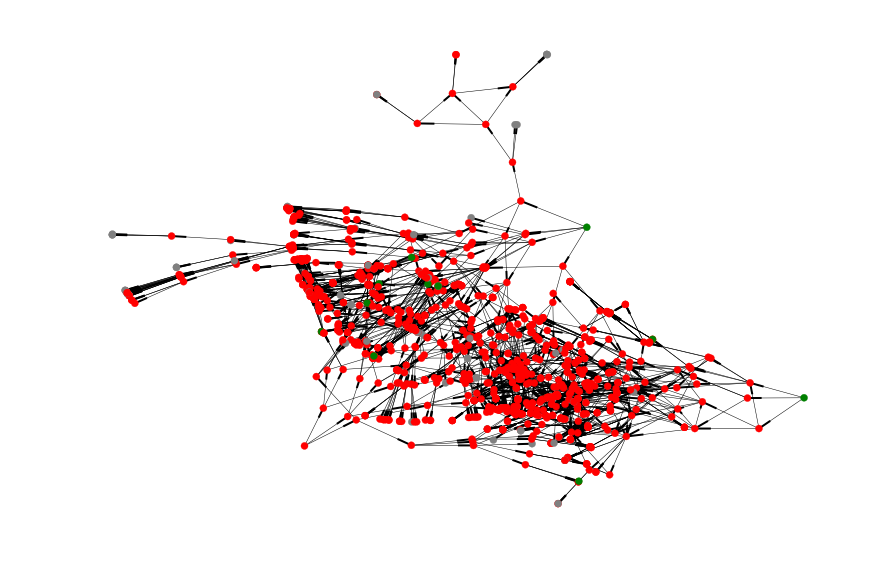

In [73]:
draw_graph(G_3, plt, print_pos=False, print_neg=False)

In [72]:
generate_user_submission(G_3, 3)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=https%3A%2F%2Fapps.npr.org%2Fbest-books-2017%2F%23%2Ftag%2Fpoetry&h=ATPbtmQc1b1Imtd8Vgp6oOCA-KvQ44cNGKeNFzMH31zwiBTvdHFSo7WLBU9RNNxoxo-2daOJSYLPclHUMjGcDLdSo-IcCohTJarAOn7yV0wfjbwWCfW98_UHaUPXG9scbR3V6AGJvcx5ZLSL-4h7MHxeuX0BL8CqyrchqKnkibDyJtF5wYdHa6_vFrmXKb9LobcyMQ1YgZ2vxgEW69C1rbM7YaPXQF74k_HSfcDAfy7qTueXUQk2NGnt0oh3-VBHeqFfgXVZj-28PdN1co_qdUTH0W_1BkA' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=https%3A%2F%2Fyourcareerquest.blogspot.com%2F&h=ATMxNdqDFpWOoWK_uINIDQuV8VdhtS25edzxDbH6ulVK2Pjsdx35A8YrZ_qWqCPkwt50Qw7sS6c8h1jIjN0_0LkP8P-lvEuFoFmpruMumQJABYMKawZk23w6fipXv5vCQzWOpV6JNQ2rRH7uaeGsAY9ptovh1SThlu_chsVCl8-7OJsRJzDhD2psRJD4Np_5UvTondf2m7y0WSqxpPLeq4tNp

Run 3 was not interesting! No courses at all :'( Don't put examples in the training data as "Dancing" could be interpreted as a negative word then. 

Makes sense that online courses are missing, dancing is best taught in person ;)

In [74]:
# Keep pipeline_2 as we created no pipeline_3
G_4 = BFS_on_next_fields(pipeline_2, field_iterator)

BFS on roots: [ 'https://www.edx.org/course/becoming-successful-leader-inclusive-catalystx-il2x-1'
 'https://www.coursera.org/browse/business/leadership-and-management?languages=en'
 'https://www.edx.org/course/becoming-successful-leader-inclusive-catalystx-il2x-1'
 'http://www.amanet.org/training/seminars/leadership-training.aspx'
 'https://www.coursera.org/browse/business/leadership-and-management?languages=en']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
..........................................................................

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.coursera.org%2Fcourse%2Fhealthforall&h=ATNiHfFK3nFeRC9jGF-v-HgqLlPBETHyuUl8R79t3s3Lg6RQlRkBj7nCmL3xANrs4SVkQDKCENU4gRAcRkTDCEMxGZfmnn29OoO-6mrZujlLyTvZxr1ucnUGwf7LOZv3bhwu18rQn5kmT7RlFYeSH6xztwwLkjR-Z6Zu6C3RVdv0SXD1iDrXAYVj3C1ZUk6T54qmn1KPJNlQGSOlne1x8CnOhJ5VKcRJout-kJfu2auA_wcfginrR_PJgbBaEBgRlyR4Dy-MyKvTVZQVhopQgs4fNw
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.coursera.org%2Fcourse%2Fhealthforall&h=ATNiHfFK3nFeRC9jGF-v-HgqLlPBETHyuUl8R79t3s3Lg6RQlRkBj7nCmL3xANrs4SVkQDKCENU4gRAcRkTDCEMxGZfmnn29OoO-6mrZujlLyTvZxr1ucnUGwf7LOZv3bhwu18rQn5kmT7RlFYeSH6xztwwLkjR-Z6Zu6C3RVdv0SXD1iDrXAYVj3C1ZUk6T54qmn1KPJNlQGSOlne1x8CnOhJ5VKcRJout-kJfu2auA_wcfginrR_PJgbBaEBgRlyR4Dy-MyKvTVZQVhopQgs4fNw'


...................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fplaybook.amanet.org%2Ftraining-articles-developing-leadership-mindset%2F%3Fpcode%3DXC12%26utm_source%3Dfacebook.com%26utm_medium%3Dreferral%26utm_campaign%3Dwebcast%26utm_content%3Dplaybook-article&h=ATNCdUsLNb0k3kPQ-EC25HD1GHZznlYtYhFaPoF_SBzZEDwrFeJx1MEgXuiv3qhFxMw0xu1168wBFSdtelt1YIubSZgL1wmv_01eWeou51ygxHjgfE2SbJfMscKVuJJ6vnjIA1ufhYmIeOJnfDZCmxA9cg5UpsYzk4lLj9ZQP_JgO9FarYJJellKBt-jqBdovvdSaVdUW2LpqxEM1Oasi85QRMVEM036Bl-enx6GWKGtOKviVXKca6ldnQNScsgWq2htXy46a4Y-gV6zt75LfUrvZGY
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fplaybook.amanet.org%2Ftraining-articles-developing-leadership-mindset%2F%3Fpcode%3DXC12%26utm_source%3Dfacebook.com%26utm_medium%3Dreferral%26utm_campaign%3Dwebcast%26utm_content%3Dplaybook-article&h=ATNCdUsLNb0k3kPQ-EC25HD1GHZznlYtYhFaPoF_SBzZEDwrFeJx1MEgXuiv3qhFxMw0xu1168wBFSdtelt1YIubSZgL1wmv_01eWeou51ygxHjgfE2SbJfMscKVuJJ6vnjIA1ufhYmIeO

.......

Exception while requesting javascript:__doPostBack('LoginStatus$LoginView$LogIn','')
No connection adapters were found for 'javascript:__doPostBack('LoginStatus$LoginView$LogIn','')'


.

Exception while requesting javascript:__doPostBack('TopNavigation1$NavLoginControl1$LoginView$LoginLink','')
No connection adapters were found for 'javascript:__doPostBack('TopNavigation1$NavLoginControl1$LoginView$LoginLink','')'


..........

Exception while requesting javascript:__doPostBack('ScheduleDisplay$SeminarRepeater$ctl03$LocationPopupLink','')
No connection adapters were found for 'javascript:__doPostBack('ScheduleDisplay$SeminarRepeater$ctl03$LocationPopupLink','')'


..

Exception while requesting javascript:__doPostBack('ScheduleDisplay$LinkButton3','')
No connection adapters were found for 'javascript:__doPostBack('ScheduleDisplay$LinkButton3','')'


........................................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2AiwOye&h=ATOWuc7CWKbBejtcFLROj5-Xbfx0JRM8YUyVsz0md3jf6D453EzGiRD8S4SyOtBNULTnSnM7En5Ypzk4WWU-FZDI39joDqmECIVEeTcleciOTGm2bQBHBHTs7shN9v2_Bt9M1cxcZTU1BnhsR18sfOaoGGTMCjvb1f2QXg0-NY7JamZ71m-UnwKIGx12sTyow87f2bX7LRoDkC3sJR3tsOloOwcGJLTacIxT2AYkOyw3U-7GQSM_EQK4KdfDAO6PIBnLKplK_P3WDKpJ0ig_mIMsGl8
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2AiwOye&h=ATOWuc7CWKbBejtcFLROj5-Xbfx0JRM8YUyVsz0md3jf6D453EzGiRD8S4SyOtBNULTnSnM7En5Ypzk4WWU-FZDI39joDqmECIVEeTcleciOTGm2bQBHBHTs7shN9v2_Bt9M1cxcZTU1BnhsR18sfOaoGGTMCjvb1f2QXg0-NY7JamZ71m-UnwKIGx12sTyow87f2bX7LRoDkC3sJR3tsOloOwcGJLTacIxT2AYkOyw3U-7GQSM_EQK4KdfDAO6PIBnLKplK_P3WDKpJ0ig_mIMsGl8'


.

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fblog.coursera.org%2Fyear-review-10-popular-courses-2017%2F&h=ATMbVQedmmzzEsONSMeWDkr4JRr13SCTYVNqnca4_lU_TRioqbpzHGqGAVM22t1QSPj9v7NZH6Yy0EFu5oNJrX4Bf5Eo5mFyaK9DIMZHKZbLU0fysf4nCNbWrZOoiCIjUlHl_gGDAG1UDYIAr1C0yWyFe8JPHGqlzX0udVOR0mhPDH_-9Vu_X4NVjZ2z8lAyIyxNKcnCHw1aCtzyynZ9vnuOoPr9gW6489EOwKKz-AXwYuHvy6lrvtXe4WDQEPeGEdQsZDtL_VzOUThrd1ZP2qbXbz5IHRHxFA
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fblog.coursera.org%2Fyear-review-10-popular-courses-2017%2F&h=ATMbVQedmmzzEsONSMeWDkr4JRr13SCTYVNqnca4_lU_TRioqbpzHGqGAVM22t1QSPj9v7NZH6Yy0EFu5oNJrX4Bf5Eo5mFyaK9DIMZHKZbLU0fysf4nCNbWrZOoiCIjUlHl_gGDAG1UDYIAr1C0yWyFe8JPHGqlzX0udVOR0mhPDH_-9Vu_X4NVjZ2z8lAyIyxNKcnCHw1aCtzyynZ9vnuOoPr9gW6489EOwKKz-AXwYuHvy6lrvtXe4WDQEPeGEdQsZDtL_VzOUThrd1ZP2qbXbz5IHRHxFA'


....

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2k3PQyC&h=ATPmVMg3qPbzKDnGljv1MY-c-EW7DuAiAoQHIWOP7o2HjJdQvFM410tobBVZXWi9KRBRxFNw8JE96q2m4KMJBliR37wT2dbdq0OhUrle2VTnjNUIhMtxvL7fA6sSgM68ag2CS0auWrQvKBXsEkWgajG8sx759ktMN6goDyliUjwFEV67ikcErt15tvMjxdm9lSQGLL36GM1Kfif30m6uMtdoY9EqCB2G3sY9aXZGLu-bDxF93hoRCAKpdNfUdNPsfS7vllcbzYDZQSDCe_kS3xHSqCs
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2k3PQyC&h=ATPmVMg3qPbzKDnGljv1MY-c-EW7DuAiAoQHIWOP7o2HjJdQvFM410tobBVZXWi9KRBRxFNw8JE96q2m4KMJBliR37wT2dbdq0OhUrle2VTnjNUIhMtxvL7fA6sSgM68ag2CS0auWrQvKBXsEkWgajG8sx759ktMN6goDyliUjwFEV67ikcErt15tvMjxdm9lSQGLL36GM1Kfif30m6uMtdoY9EqCB2G3sY9aXZGLu-bDxF93hoRCAKpdNfUdNPsfS7vllcbzYDZQSDCe_kS3xHSqCs'


...............

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fcloud.google.com%2Fblog%2Fbig-data%2F2017%2F11%2Fgoogle-cloud-provides-a-unified-streamlined-way-to-execute-your-ml-strategy&h=ATPyS36yem2yZw32ay9PTzYeIvpiJhqyLqgaYDwl9f0QRRcct_RAvVgxY84UcrdXTKc1XFAJHiW1r8oklfUnKoCd6LRYo13IRY_ceMB1gaBarB4gu-NhAm2YWE83Zl7tYzppZafPOC6TbSCdixR3ciU3Z1CigairloDKGght2-RCESyOQ-_bElE0SC5kRFbaGhtZYS1Gs-hdsXWVyhmLaTmLIm-p3xgIrDUyEEE1g3FTbsJXAEl7Q8bzfZHA759iXjmoxZXkzxKMzaUrh39cl8FMkUs
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fcloud.google.com%2Fblog%2Fbig-data%2F2017%2F11%2Fgoogle-cloud-provides-a-unified-streamlined-way-to-execute-your-ml-strategy&h=ATPyS36yem2yZw32ay9PTzYeIvpiJhqyLqgaYDwl9f0QRRcct_RAvVgxY84UcrdXTKc1XFAJHiW1r8oklfUnKoCd6LRYo13IRY_ceMB1gaBarB4gu-NhAm2YWE83Zl7tYzppZafPOC6TbSCdixR3ciU3Z1CigairloDKGght2-RCESyOQ-_bElE0SC5kRFbaGhtZYS1Gs-hdsXWVyhmLaTmLIm-p3xgIrDUyEEE1g3FTbsJXAEl7Q8bzfZHA759iXjmoxZXkzxKMzaUrh39cl8FMkUs'


..

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATMZLXl9y3mB9Ibcy6EUgZjumXoR94tdiwmsdfMmhY-oZGijm91PmSTwREB0Jncv_GFpJKu22tYRw0NbcsLYZvYtp9CiOV4fJ5F1JHdfNThy7NYg7PaViUds4yOMryYtcIl8fKnB25-8DFGFquJ2ZqzB-wPpvp-fyE4FHLsgZnF_qdpZ5wYnZrpBaqGn0oNjm0iuzPSKoL9ks3sGIyXWZObcg2b3qrC6TICPqwTBQnxUrn-Y-3_kJWstBvOglhHVoRFFS4Dchc4ayCK_s0dfKkkx1hQ
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATMZLXl9y3mB9Ibcy6EUgZjumXoR94tdiwmsdfMmhY-oZGijm91PmSTwREB0Jncv_GFpJKu22tYRw0NbcsLYZvYtp9CiOV4fJ5F1JHdfNThy7NYg7PaViUds4yOMryYtcIl8fKnB25-8DFGFquJ2ZqzB-wPpvp-fyE4FHLsgZnF_qdpZ5wYnZrpBaqGn0oNjm0iuzPSKoL9ks3sGIyXWZObcg2b3qrC6TICPqwTBQnxUrn-Y-3_kJWstBvOglhHVoRFFS4Dchc4ayCK_s0dfKkkx1hQ'


...........................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


..............................................

Exception while parsing https://www.linkedin.com/company/american-management-association
'NoneType' object has no attribute 'findAll'


.............................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


..................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


......................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


..........................................................................................

Exception while requesting mailto:kirill@topolyan.com
No connection adapters were found for 'mailto:kirill@topolyan.com'


.

Exception while requesting skype:k_topolyan
No connection adapters were found for 'skype:k_topolyan'


..................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2yZPu1h&h=ATOsSI_ByRN2CK-oeh7ZXIKnLmRoGlRhvSXS7p-XJX8AWQ0Ljho_ueTIGuXB1YC3fZfJKEAhQideJ0VdhrWVdwikbyc8fhiZ78mXaDFYSFXQ_RCIrBNIf_4_pnY0sFsccmYDQcotoVIUc47NTE8aJy-jg3jCtXr1VFu-oDFsGAdJRpWPpqhXNmPFKDuyDNNoVCPsH5v-wmy-_ifNNhAu-Eq4Gza5ZrpnuJ48nSUCTZhObee9r37m5q57p-TbPuEa5ot5AL5ca_GzzuU5KDxQ3TB2Gvs
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2yZPu1h&h=ATOsSI_ByRN2CK-oeh7ZXIKnLmRoGlRhvSXS7p-XJX8AWQ0Ljho_ueTIGuXB1YC3fZfJKEAhQideJ0VdhrWVdwikbyc8fhiZ78mXaDFYSFXQ_RCIrBNIf_4_pnY0sFsccmYDQcotoVIUc47NTE8aJy-jg3jCtXr1VFu-oDFsGAdJRpWPpqhXNmPFKDuyDNNoVCPsH5v-wmy-_ifNNhAu-Eq4Gza5ZrpnuJ48nSUCTZhObee9r37m5q57p-TbPuEa5ot5AL5ca_GzzuU5KDxQ3TB2Gvs'


..................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2p7gFaP&h=ATOIsY65dMCJPSySHjupH6neeSNdmTuYXijYAq19QK2XGkHO6zWd0IZmmkHPEsaqixtFIgojp7PjqUe05aVBqk78Jm7CvPgwAhqzO_fCEas-8FqFzLcwlP1egGdepXle2ahPY2N-itYLCCrNg2y4FKnjdRSX8IcZqIgWvFG0XwOkVpJx2GUrd4aUvWbEaArK7Ouil0DvkX8aY8aOtl7u1v1SRYyIU0FIvBms-zj3SDR1GEiMeEnNacoJB-0sj-ht_fQSo5zEau-OQr0RYQlb0s7IMHI
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2p7gFaP&h=ATOIsY65dMCJPSySHjupH6neeSNdmTuYXijYAq19QK2XGkHO6zWd0IZmmkHPEsaqixtFIgojp7PjqUe05aVBqk78Jm7CvPgwAhqzO_fCEas-8FqFzLcwlP1egGdepXle2ahPY2N-itYLCCrNg2y4FKnjdRSX8IcZqIgWvFG0XwOkVpJx2GUrd4aUvWbEaArK7Ouil0DvkX8aY8aOtl7u1v1SRYyIU0FIvBms-zj3SDR1GEiMeEnNacoJB-0sj-ht_fQSo5zEau-OQr0RYQlb0s7IMHI'


...............

Exception while requesting http://www.linkedin.com/shareArticle?mini=true&title=Top%2010%20Career%20Launching%20Courses%20of%202017&url=https://blog.coursera.org/top-10-career-launching-courses-2017/&summary=We%E2%80%99ve+highlighted+the+top+ten+courses+that+have+launched+careers+for+learners+around+the+world.+%0D%0A...
[Errno 36] File name too long: 'webpages/experiment1/cache/http:,,www.linkedin.com,shareArticle?mini=true&title=Top%2010%20Career%20Launching%20Courses%20of%202017&url=https:,,blog.coursera.org,top-10-career-launching-courses-2017,&summary=We%E2%80%99ve+highlighted+the+top+ten+courses+that+have+launched+careers+for+learners+around+the+world.+%0D%0A...'


...........................................................................

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubSolutionsRepeater$ctl04$SubSolutionLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubSolutionsRepeater$ctl04$SubSolutionLink','')'


......................

Exception while requesting mailto:customerservice@amanet.org
No connection adapters were found for 'mailto:customerservice@amanet.org'


........

Exception while parsing http://www.linkedin.com/company/ama-executive-conference-centers
'NoneType' object has no attribute 'findAll'


....

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl20$StateLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl20$StateLink','')'


.

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$LevelsRepeater$ctl08$LevelLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$LevelsRepeater$ctl08$LevelLink','')'


......

Exception while requesting javascript:showModalLayer('tellAcolleague')
No connection adapters were found for 'javascript:showModalLayer('tellAcolleague')'


...

Exception while requesting javascript:showModalLayer('podcast_subscribe');
No connection adapters were found for 'javascript:showModalLayer('podcast_subscribe');'


.......

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl03$PrimarySubjectLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl03$PrimarySubjectLink','')'


.

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl08$StateLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl08$StateLink','')'


.

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl09$PrimarySubjectLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl09$PrimarySubjectLink','')'


.......

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl00$PrimarySubjectLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl00$PrimarySubjectLink','')'


.

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$CreditsRepeater$ctl10$Credits','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$CreditsRepeater$ctl10$Credits','')'


.............

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl21$PrimarySubjectLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl21$PrimarySubjectLink','')'


...............................................

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl21$PrimarySubjectLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$SubjectRepeater$ctl21$PrimarySubjectLink','')'


.....

Exception while requesting mailto:SpecSlsWeb@amanet.org
No connection adapters were found for 'mailto:SpecSlsWeb@amanet.org'


.....

Exception while requesting mailto:pubservice@amanet.org
No connection adapters were found for 'mailto:pubservice@amanet.org'


...........

Exception while requesting mailto:customerservice@amanet.org
No connection adapters were found for 'mailto:customerservice@amanet.org'


.........

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl06$StateLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl06$StateLink','')'


.

Exception while requesting javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl04$StateLink','')
No connection adapters were found for 'javascript:__doPostBack('ParametricNavigationControl$StatesRepeater$ctl04$StateLink','')'


..........................................................................................................................................................................................Crawling finished after 1098.3046560287476s


In [75]:
nx.write_gpickle(G_4, os.path.join('saved', 'graphs', 'G_4.pickle'))

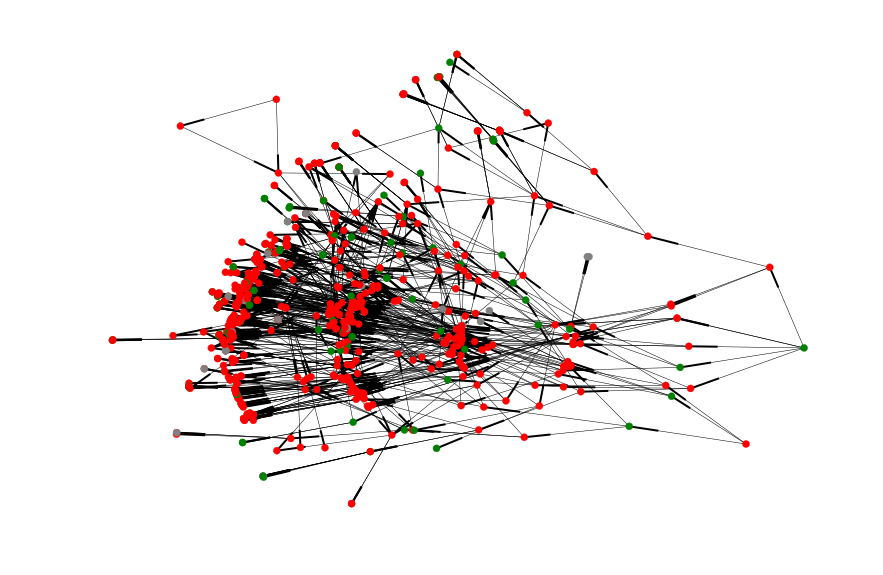

In [76]:
draw_graph(G_4, plt, print_pos=False, print_neg=False)

In [80]:
generate_user_submission(G_4, 4)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=https%3A%2F%2Fblog.coursera.org%2Fyear-review-10-popular-courses-2017%2F&h=ATMbVQedmmzzEsONSMeWDkr4JRr13SCTYVNqnca4_lU_TRioqbpzHGqGAVM22t1QSPj9v7NZH6Yy0EFu5oNJrX4Bf5Eo5mFyaK9DIMZHKZbLU0fysf4nCNbWrZOoiCIjUlHl_gGDAG1UDYIAr1C0yWyFe8JPHGqlzX0udVOR0mhPDH_-9Vu_X4NVjZ2z8lAyIyxNKcnCHw1aCtzyynZ9vnuOoPr9gW6489EOwKKz-AXwYuHvy6lrvtXe4WDQEPeGEdQsZDtL_VzOUThrd1ZP2qbXbz5IHRHxFA' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.coursera.org%2Fcourse%2Fhealthforall&h=ATNiHfFK3nFeRC9jGF-v-HgqLlPBETHyuUl8R79t3s3Lg6RQlRkBj7nCmL3xANrs4SVkQDKCENU4gRAcRkTDCEMxGZfmnn29OoO-6mrZujlLyTvZxr1ucnUGwf7LOZv3bhwu18rQn5kmT7RlFYeSH6xztwwLkjR-Z6Zu6C3RVdv0SXD1iDrXAYVj3C1ZUk6T54qmn1

Verdict filled here. Didn't add too much as I did not want to flood training set with coursera

In [83]:
df_verdict = read_user_verdict(4)
user_verdict_report(df_verdict)
save_verdict_to_training(df_verdict, 4)

==User verdict report==
    True negatives: 3
    True positives: 7
    False negatives: 2
    False positives: 10
    Failures / not done: 673
    


In [84]:
previous_train_folders = ['train-0', 'train-1', 'train-2', 'train-4']
pipeline_4, accuracy_4_easy, accuracy_4_hard = analyse_easy_hard(previous_train_folders, folder_test_easy, folder_test_hard, download_pages=True)

Error while downloading: https://www.economist.com/digital. Status code: 403
Error while downloading: http://blog.openclassrooms.com/en/. Status code: 403
Trying again to download 0 pages one at a time
Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.63      0.96      0.76        47
       True       0.93      0.49      0.64        51

avg / total       0.79      0.71      0.70        98

[[45  2]
 [26 25]]
Accuracy: 0.7142857142857143
==Hard task==
             precision    rec

In [85]:
G_5 = BFS_on_next_fields(pipeline_4, field_iterator)

BFS on roots: ['https://www.udacity.com/course/college-algebra--ma008'
 'https://www.coursera.org/courses?languages=en&query=algebra'
 'https://ocw.mit.edu/courses/mathematics/18-701-algebra-i-fall-2010/'
 'https://www.edx.org/course/introduction-algebra-schoolyourself-algebrax-1'
 'https://www.coursera.org/courses?languages=en&query=algebra']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
.........................................................................................................................................................................................................

Exception while requesting https://twitter.com/share?lang=en&text=What+is+the+difference+between+the+Associate+Android+Developer+Fast+Track+program+and+the+Android+Developer+Nanodegr...&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217992923-What-is-the-difference-between-the-Associate-Android-Developer-Fast-Track-program-and-the-Android-Developer-Nanodegree-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,twitter.com,share?lang=en&text=What+is+the+difference+between+the+Associate+Android+Developer+Fast+Track+program+and+the+Android+Developer+Nanodegr...&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217992923-What-is-the-difference-between-the-Associate-Android-Developer-Fast-Track-program-and-the-Android-Developer-Nanodegree-'


.......................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


......

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


...

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


..........................................................................................

Exception while requesting https://www.linkedin.com/uas/login?session_redirect=https%3A%2F%2Fwww%2Elinkedin%2Ecom%2Fsharing%2Fshare-offsite%3Fmini%3Dtrue%26url%3Dhttp%3A%2F%2Focw%2Emit%2Eedu%2Fhelp%2Ffaq-ocw-scholar%2F%26title%3DOCW%2520Scholar%26summary%3DLearn%2520from%2520the%2520same%2520materials%2520MIT%2520students%2520use%2520in%2520class%2E&fromSignIn=true&trk=uno-reg-join-sign-in
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.linkedin.com,uas,login?session_redirect=https%3A%2F%2Fwww%2Elinkedin%2Ecom%2Fsharing%2Fshare-offsite%3Fmini%3Dtrue%26url%3Dhttp%3A%2F%2Focw%2Emit%2Eedu%2Fhelp%2Ffaq-ocw-scholar%2F%26title%3DOCW%2520Scholar%26summary%3DLearn%2520from%2520the%2520same%2520materials%2520MIT%2520students%2520use%2520in%2520class%2E&fromSignIn=true&trk=uno-reg-join-sign-in'


.......................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fow.ly%2F5XLV30hkuXy&h=ATPSnuzGHMDf9qnNrf1SS2B_mWLwpINiohMh2kdVYF5yHl1VF8tWrhjDZeTEIEm45r81_ZuQ0IDVJf3gDm64MrzRElZm1dceqN7YNSHZgu9YGoan54qLFyl775hpqD16wopUsDbMMmvMBfVdBB4QF96NR6TRgn4sHrQzZqQtDVVG6azCV2UNGM0O7NkziaMquPulUj4SyUwYFtIXbpf-fs_AsO3gLWFGJFCVX0eTqtb3TCFf56ayqKPez3lxzrop9KSd29Lf7Ykl1_Xnu3BlrhQ
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fow.ly%2F5XLV30hkuXy&h=ATPSnuzGHMDf9qnNrf1SS2B_mWLwpINiohMh2kdVYF5yHl1VF8tWrhjDZeTEIEm45r81_ZuQ0IDVJf3gDm64MrzRElZm1dceqN7YNSHZgu9YGoan54qLFyl775hpqD16wopUsDbMMmvMBfVdBB4QF96NR6TRgn4sHrQzZqQtDVVG6azCV2UNGM0O7NkziaMquPulUj4SyUwYFtIXbpf-fs_AsO3gLWFGJFCVX0eTqtb3TCFf56ayqKPez3lxzrop9KSd29Lf7Ykl1_Xnu3BlrhQ'


.................................................

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.inc.com%2Fjessica-stillman%2Fthe-10-most-popular-coursera-courses-of-year.html&h=ATPPFjnMihHXnvf2DWcW3fD3gvtuZYLYMudXkoMTPEjGz485oCwcxwsby2M-EblXeh2WJ9P_ofYnfAAJVTBVRPCH7EM8IF7XAvJnTWg4OHfvrGe9JTkg7NiZAoZdmK_g7XNpg6LtCyiw3UCXX8C3GfuBOIOU-ooO4Kl7kfMyzgKEJSpFVdlbyDO3Qm1qHKkwrMeCT01zDUYKAXHkRtNCunCOkb4bpCaACxJWYsDg5Alr88lcZ28DjHtShp00h1cHeyVb7dqtyrTjVwdtT3aSie8mjHc
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.inc.com%2Fjessica-stillman%2Fthe-10-most-popular-coursera-courses-of-year.html&h=ATPPFjnMihHXnvf2DWcW3fD3gvtuZYLYMudXkoMTPEjGz485oCwcxwsby2M-EblXeh2WJ9P_ofYnfAAJVTBVRPCH7EM8IF7XAvJnTWg4OHfvrGe9JTkg7NiZAoZdmK_g7XNpg6LtCyiw3UCXX8C3GfuBOIOU-ooO4Kl7kfMyzgKEJSpFVdlbyDO3Qm1qHKkwrMeCT01zDUYKAXHkRtNCunCOkb4bpCaACxJWYsDg5Alr88lcZ28DjHtShp00h1cHeyVb7dqtyrTjVwdtT3aSie8mjHc'


..........................................................................................................................................

Exception while requesting https://accounts.google.com/AccountChooser?continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0&service=oz
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,accounts.google.com,AccountChooser?continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0&service=oz'


.

Exception while requesting https://accounts.google.com/SignUp?service=oz&continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,accounts.google.com,SignUp?service=oz&continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0'


.

Exception while requesting https://accounts.google.com/signin/usernamerecovery?continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0&service=oz&hl=en
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,accounts.google.com,signin,usernamerecovery?continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0&service=oz&hl=en'


..............

Exception while requesting https://www.facebook.com/share.php?title=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.facebook.com,share.php?title=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-'


...

Exception while requesting https://www.facebook.com/share.php?title=I+know+you+offer+the+opportunity+for+students+to+pause+their+studies+in+other+programs%3B+will+that+be+an+option+for+this+program%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077466-I-know-you-offer-the-opportunity-for-students-to-pause-their-studies-in-other-programs-will-that-be-an-option-for-this-program-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.facebook.com,share.php?title=I+know+you+offer+the+opportunity+for+students+to+pause+their+studies+in+other+programs%3B+will+that+be+an+option+for+this+program%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077466-I-know-you-offer-the-opportunity-for-students-to-pause-their-studies-in-other-programs-will-that-be-an-option-for-this-program-'


.

Exception while requesting https://twitter.com/share?lang=en&text=I+know+you+offer+the+opportunity+for+students+to+pause+their+studies+in+other+programs%3B+will+that+be+an+option+for+t...&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077466-I-know-you-offer-the-opportunity-for-students-to-pause-their-studies-in-other-programs-will-that-be-an-option-for-this-program-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,twitter.com,share?lang=en&text=I+know+you+offer+the+opportunity+for+students+to+pause+their+studies+in+other+programs%3B+will+that+be+an+option+for+t...&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077466-I-know-you-offer-the-opportunity-for-students-to-pause-their-studies-in-other-programs-will-that-be-an-option-for-this-program-'


.....

Exception while requesting https://twitter.com/share?lang=en&text=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,twitter.com,share?lang=en&text=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-'


.

Exception while requesting https://www.facebook.com/share.php?title=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.facebook.com,share.php?title=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-'


..........

Exception while requesting https://www.linkedin.com/shareArticle?mini=true&source=Udacity&title=How+many+hours+a+week+should+I+expect+to+spend+on+my+coursework+in+order+to+succeed+in+this+program%3F&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217992743-How-many-hours-a-week-should-I-expect-to-spend-on-my-coursework-in-order-to-succeed-in-this-program-
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,www.linkedin.com,shareArticle?mini=true&source=Udacity&title=How+many+hours+a+week+should+I+expect+to+spend+on+my+coursework+in+order+to+succeed+in+this+program%3F&url=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217992743-How-many-hours-a-week-should-I-expect-to-spend-on-my-coursework-in-order-to-succeed-in-this-program-'


...............

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


........

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


.......

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


......................................................................................................................................................

Exception while parsing https://www.linkedin.com/in/rsumbaly
'NoneType' object has no attribute 'findAll'


................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2zkz0V3&h=ATOykBl5-yR0srA0Ihvjq8Gxbay-lvWHvEpsJJKmCINmUCSd05shWUQYKd4N6CCW6lkFh7fXg0w-qLSZ8jNGNojKEe-3auAPzHDfgh4ySliA5wQ062BaFwNxaFCU-aeLcVDWlrXFiy0Im71P_dhmOBwut6v06Q2SVg0aAShq5JkZ8SkySrz63Hi6p7MChkarIA6y_HTDHaMC-5_6eQwxOskiXF4HP0RPapn5tUfPQTY-ukDk3MetHBQppzOxsSDYfbO9UDo8EQ2NYwHEHxAT6_LstMk
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2zkz0V3&h=ATOykBl5-yR0srA0Ihvjq8Gxbay-lvWHvEpsJJKmCINmUCSd05shWUQYKd4N6CCW6lkFh7fXg0w-qLSZ8jNGNojKEe-3auAPzHDfgh4ySliA5wQ062BaFwNxaFCU-aeLcVDWlrXFiy0Im71P_dhmOBwut6v06Q2SVg0aAShq5JkZ8SkySrz63Hi6p7MChkarIA6y_HTDHaMC-5_6eQwxOskiXF4HP0RPapn5tUfPQTY-ukDk3MetHBQppzOxsSDYfbO9UDo8EQ2NYwHEHxAT6_LstMk'


.........................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


....

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


....................................

Exception while requesting http://nptel.iitm.ac.in/
HTTPConnectionPool(host='nptel.iitm.ac.in', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0cd5efcc0>: Failed to establish a new connection: [Errno -5] No address associated with hostname',))


..................................

Exception while requesting http://oeit-tsa.mit.edu/teachingexcellence/?p=17
HTTPConnectionPool(host='oeit-tsa.mit.edu', port=80): Max retries exceeded with url: /teachingexcellence/?p=17 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0f27dfe10>: Failed to establish a new connection: [Errno 110] Connection timed out',))


...........................

Exception while parsing http://www.linkedin.com/directory/people-a/?trk=hb_ft_peopledir
'NoneType' object has no attribute 'findAll'
Exception while parsing https://www.linkedin.com/pulse/discover?trk=hb_ft_influencers
'NoneType' object has no attribute 'findAll'
Exception while parsing http://www.linkedin.com/company/linkedin/careers?trk=hb_ft_work
'NoneType' object has no attribute 'findAll'
Exception while parsing http://www.linkedin.com/directory/people-a/?trk=hb_ft_peopledir
'NoneType' object has no attribute 'findAll'


..........................................

Exception while requesting http://andreas.com/
HTTPConnectionPool(host='andreas.com', port=80): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0f0e16860>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))


......

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


..........................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


.........................................................................................................................

Exception while requesting mailto:?subject=Check out this Coursera post: &body=I thought you might be interested in this post from Coursera: https://blog.coursera.org/top-10-career-launching-courses-2017/
No connection adapters were found for 'mailto:?subject=Check out this Coursera post: &body=I thought you might be interested in this post from Coursera: https://blog.coursera.org/top-10-career-launching-courses-2017/'


...........................................................

Exception while requesting mailto:cclose@coursera.org
No connection adapters were found for 'mailto:cclose@coursera.org'


................

Exception while requesting fb-messenger://share?app_id=58567469885&redirect_uri=http%3A%2F%2Fwww.bbc.com%2Fnews%2Fbusiness-28882749&link=http%3A%2F%2Fwww.bbc.com%2Fnews%2Fbusiness-28882749%3FCMP%3Dshare_btn_me
No connection adapters were found for 'fb-messenger://share?app_id=58567469885&redirect_uri=http%3A%2F%2Fwww.bbc.com%2Fnews%2Fbusiness-28882749&link=http%3A%2F%2Fwww.bbc.com%2Fnews%2Fbusiness-28882749%3FCMP%3Dshare_btn_me'


...............................................................Crawling finished after 2487.252705335617s


In [86]:
nx.write_gpickle(G_5, os.path.join('saved', 'graphs', 'G_5.pickle'))

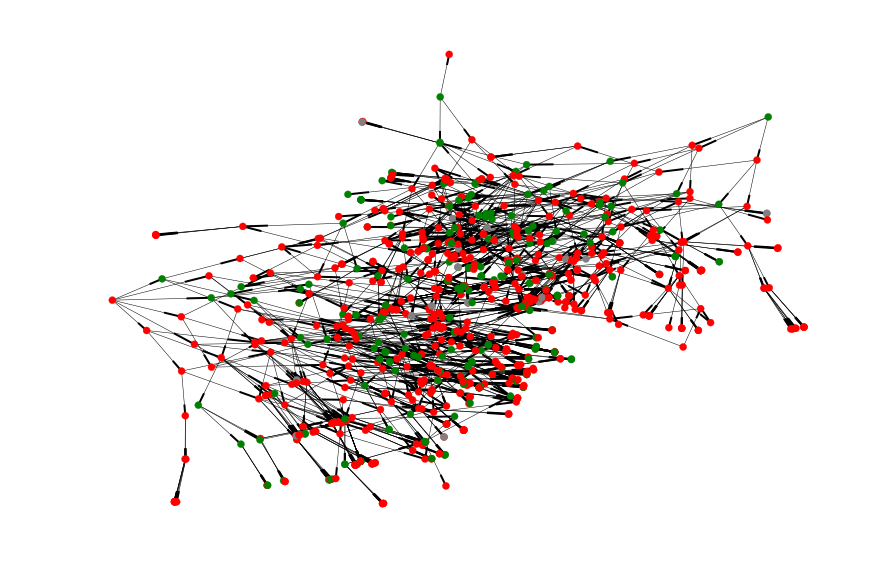

In [89]:
draw_graph(G_5, plt, print_pos=False, print_neg=False)

In [90]:
generate_user_submission(G_5, 5)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://www.facebook.com/share.php?title=If+I+have+already+taken+the+Android+Beginner+Nanodegree%2C+can+I+take+this+as+well%3F&u=https%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F217077486-If-I-have-already-taken-the-Android-Beginner-Nanodegree-can-I-take-this-as-well-' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://accounts.google.com/SignUp?service=oz&continue=https%3A%2F%2Fplus.google.com%2Fup%2F%3Fcontinue%3Dhttps%3A%2F%2Fplus.google.com%2Fshare%3Fhl%253Den-us%2526url%253Dhttps%3A%2F%2Fudacity.zendesk.com%2Fhc%2Fen-us%2Farticles%2F115001236906-What-jobs-will-the-Robotics-Nanodegree-program-prepare-me-for-%26gpsrc%3Dgplp0' with link or location/anchor > 255 characters since it exceeds Excel's limit fo

Verdict filled here.

In [91]:
df_verdict = read_user_verdict(5)
user_verdict_report(df_verdict)
save_verdict_to_training(df_verdict, 5)

==User verdict report==
    True negatives: 9
    True positives: 15
    False negatives: 1
    False positives: 15
    Failures / not done: 850
    


In [92]:
previous_train_folders = ['train-0', 'train-1', 'train-2', 'train-4', 'train-5']
pipeline_5, accuracy_5_easy, accuracy_5_hard = analyse_easy_hard(previous_train_folders, folder_test_easy, folder_test_hard, download_pages=True)

Error while downloading: http://blog.openclassrooms.com/en/. Status code: 403
Error while downloading: https://www.economist.com/digital. Status code: 403
Trying again to download 0 pages one at a time
Constructing text dataframes
Skipped https://www.skillshare.com/classes/Low-Budget-Filmmaking-—-Tips-and-Tricks-for-an-Indie-Look/1077872333, was not cached
Skipped http://blog.openclassrooms.com/en/, was not cached
Skipped https://www.skillshare.com, was not cached
Skipped https://app.pluralsight.com/id?, was not cached
Skipped https://www.economist.com/digital, was not cached
Skipped http://blog.creativelive.com, was not cached
Training the model
Predictions on test sets
==Easy task==
             precision    recall  f1-score   support

      False       0.67      0.96      0.79        47
       True       0.94      0.57      0.71        51

avg / total       0.81      0.76      0.75        98

[[45  2]
 [22 29]]
Accuracy: 0.7551020408163265
==Hard task==
             precision    rec

In [93]:
G_6 = BFS_on_next_fields(pipeline_5, field_iterator)

BFS on roots: ['https://www.edx.org/course/subject/biology-life-sciences'
 'https://www.edx.org/course/subject/biology-life-sciences'
 'https://www.lscore.ucla.edu/courses/'
 'https://www.coursera.org/browse/life-sciences?languages=en'
 'https://ocw.mit.edu/courses/life-sciences/']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
......................................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


..................................................................................................................

Exception while requesting mailto:ejurado@lifesci.ucla.edu
No connection adapters were found for 'mailto:ejurado@lifesci.ucla.edu'


.........................

Exception while parsing http://lslab.lscore.ucla.edu
'NoneType' object has no attribute 'findAll'


...................................................................................................................................................................

Exception while requesting mailto:ocw-outreach@mit.edu
No connection adapters were found for 'mailto:ocw-outreach@mit.edu'


..............................................

Exception while parsing http://lslab.lscore.ucla.edu
'NoneType' object has no attribute 'findAll'


..................................

Exception while requesting javascript:;
No connection adapters were found for 'javascript:;'


.............................

Exception while requesting mailto:lizroth@ucla.edu
No connection adapters were found for 'mailto:lizroth@ucla.edu'


.

Exception while requesting mailto:dcohn@mcdb.ucla.edu
No connection adapters were found for 'mailto:dcohn@mcdb.ucla.edu'


.

Exception while requesting mailto:chenjn@mcdb.ucla.edu
No connection adapters were found for 'mailto:chenjn@mcdb.ucla.edu'


.................................

Exception while requesting mailto:rdieckmann@ioe.ucla.edu
No connection adapters were found for 'mailto:rdieckmann@ioe.ucla.edu'


.......................................

Exception while requesting mailto:press@zendesk.com
No connection adapters were found for 'mailto:press@zendesk.com'


.....................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


...

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


...............................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATPwBqHcvm-A4QRRQUxam9q_3ACZgVZG2HArXxFttjjlP-JKx8D1p6Y3dm-Ag4c66PppK7RUYgYQSzKc41zs4uXk7O9XxcSWEWwvkvSpS9PpR0_GvTYLsOFiYTpcs4l_-hiyC0XI8StV_4a1WImCS1c0PCwsTuz-1aQ7DUwlpPRy3kqpFtLt4JwOXrl-DSlHqz13PStOIyEVdGhYCCprWiNcG0n7cRTeixVI47THVnV1z7aE1dWwlXjL1jTojF3h7UTPjui5DxQfxJOc5002TkX3OrE
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATPwBqHcvm-A4QRRQUxam9q_3ACZgVZG2HArXxFttjjlP-JKx8D1p6Y3dm-Ag4c66PppK7RUYgYQSzKc41zs4uXk7O9XxcSWEWwvkvSpS9PpR0_GvTYLsOFiYTpcs4l_-hiyC0XI8StV_4a1WImCS1c0PCwsTuz-1aQ7DUwlpPRy3kqpFtLt4JwOXrl-DSlHqz13PStOIyEVdGhYCCprWiNcG0n7cRTeixVI47THVnV1z7aE1dWwlXjL1jTojF3h7UTPjui5DxQfxJOc5002TkX3OrE'


.............................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATMOQ9dkfdA9Bh5eFAYFh4ZLJzTRjyKCJPaTlZsLqLIWYizrp4Sj35xt4AIOV1T-_gWI1tCII93t7drM9IXqTC10tn-zrkxveKrN7iFrNwnYvkLGFurchuqFiL2uAODGiSPs8KJ8CoHgEGCk3ILuWFJ3c2r7akrT7ScUOp9XYlQjT-4LKCjiErgWwRDvujQsapeQksmN4v5enk983bBV_XKcqNtouFiqPCZFd1TbyiBOrkBd8vpA5jPaYSrE-Z8DZzH5d2VcWYKyE7GSzLiixKR9joI
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATMOQ9dkfdA9Bh5eFAYFh4ZLJzTRjyKCJPaTlZsLqLIWYizrp4Sj35xt4AIOV1T-_gWI1tCII93t7drM9IXqTC10tn-zrkxveKrN7iFrNwnYvkLGFurchuqFiL2uAODGiSPs8KJ8CoHgEGCk3ILuWFJ3c2r7akrT7ScUOp9XYlQjT-4LKCjiErgWwRDvujQsapeQksmN4v5enk983bBV_XKcqNtouFiqPCZFd1TbyiBOrkBd8vpA5jPaYSrE-Z8DZzH5d2VcWYKyE7GSzLiixKR9joI'


....

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATOy1ePdhOTAx9-qxFOtVz_I7jyKa51IhbFGOnbe5vC8j4oiwW6PNChzdpepNl-7DM4XfvHFm6KeHIQQjLyJu1Mg1bzfUcGajGJ-6e2Yn_qwLRimM7Dz09jpE070vEwxpf8knru-eQGs6a1X5JTj8l8tJKreaYvHJv9J0PSTARfFmtqAQSNl9pLL7lRrwnJhmv-GlZUVKP40B_aWY0D0RFilXWHswFVj0IlNR82YY8KHKZdQYNfenK3cZ4Hbj1h3Gla-Jg0En-Mlx6tochzri_oK_Q8
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATOy1ePdhOTAx9-qxFOtVz_I7jyKa51IhbFGOnbe5vC8j4oiwW6PNChzdpepNl-7DM4XfvHFm6KeHIQQjLyJu1Mg1bzfUcGajGJ-6e2Yn_qwLRimM7Dz09jpE070vEwxpf8knru-eQGs6a1X5JTj8l8tJKreaYvHJv9J0PSTARfFmtqAQSNl9pLL7lRrwnJhmv-GlZUVKP40B_aWY0D0RFilXWHswFVj0IlNR82YY8KHKZdQYNfenK3cZ4Hbj1h3Gla-Jg0En-Mlx6tochzri_oK_Q8'


...........................................................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


...........................................................................

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


.....................................................................

Exception while requesting https://adclick.g.doubleclick.net/aclk?sa=L&ai=BfZLA-ojyVpe1OJaN3QHKmITADevz3p4EAAAAEAEg94TLDTgAWKvjjp-LAWDJlu6IhKTsD7IBC29jdy5taXQuZWR1ugEJZ2ZwX2ltYWdlyAEJ2gETaHR0cDovL29jdy5taXQuZWR1L8ACAuACAOoCGS8xMDY0OTE3L0hPTUVfQ09SUF9MT0dPXzb4AoPSHpAD4AOYA-ADqAMB0ASQTuAEAdIFBRCTpK8VkAYBoAYW2AcA4AcL&num=0&cid=5GgSpNzQjXr6QUaD5i0ByHuw&sig=AOD64_2PeqZ3jmV0LCcCXa8lukJXZEnt4w&client=ca-pub-6588555046597237&adurl=http://www.dow.com/
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,adclick.g.doubleclick.net,aclk?sa=L&ai=BfZLA-ojyVpe1OJaN3QHKmITADevz3p4EAAAAEAEg94TLDTgAWKvjjp-LAWDJlu6IhKTsD7IBC29jdy5taXQuZWR1ugEJZ2ZwX2ltYWdlyAEJ2gETaHR0cDovL29jdy5taXQuZWR1L8ACAuACAOoCGS8xMDY0OTE3L0hPTUVfQ09SUF9MT0dPXzb4AoPSHpAD4AOYA-ADqAMB0ASQTuAEAdIFBRCTpK8VkAYBoAYW2AcA4AcL&num=0&cid=5GgSpNzQjXr6QUaD5i0ByHuw&sig=AOD64_2PeqZ3jmV0LCcCXa8lukJXZEnt4w&client=ca-pub-6588555046597237&adurl=http:,,www.dow.com,'


..

Exception while requesting https://adclick.g.doubleclick.net/aclk?sa=L&ai=BZxab-ojyVpK1OJaN3QHKmITADeOS354EAAAAEAEg94TLDTgAWPOWj5-LAWDJlu6IhKTsD7IBC29jdy5taXQuZWR1ugEJZ2ZwX2ltYWdlyAEJ2gETaHR0cDovL29jdy5taXQuZWR1L8ACAuACAOoCGS8xMDY0OTE3L0hPTUVfQ09SUF9MT0dPXzH4AoPSHpAD4AOYA-ADqAMB0ASQTuAEAdIFBRD7pq8VkAYBoAYW2AcA4AcL&num=0&cid=5GgU3FUiGrTUm6Pu6-Q-0kcG&sig=AOD64_0uHWl6tH9gNwZT5-9LEB7wl5vRbg&client=ca-pub-6588555046597237&adurl=http://www.academica.mx/
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,adclick.g.doubleclick.net,aclk?sa=L&ai=BZxab-ojyVpK1OJaN3QHKmITADeOS354EAAAAEAEg94TLDTgAWPOWj5-LAWDJlu6IhKTsD7IBC29jdy5taXQuZWR1ugEJZ2ZwX2ltYWdlyAEJ2gETaHR0cDovL29jdy5taXQuZWR1L8ACAuACAOoCGS8xMDY0OTE3L0hPTUVfQ09SUF9MT0dPXzH4AoPSHpAD4AOYA-ADqAMB0ASQTuAEAdIFBRD7pq8VkAYBoAYW2AcA4AcL&num=0&cid=5GgU3FUiGrTUm6Pu6-Q-0kcG&sig=AOD64_0uHWl6tH9gNwZT5-9LEB7wl5vRbg&client=ca-pub-6588555046597237&adurl=http:,,www.academica.mx,'


......................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


..........Crawling finished after 1060.9559581279755s


In [94]:
nx.write_gpickle(G_6, os.path.join('saved', 'graphs', 'G_6.pickle'))

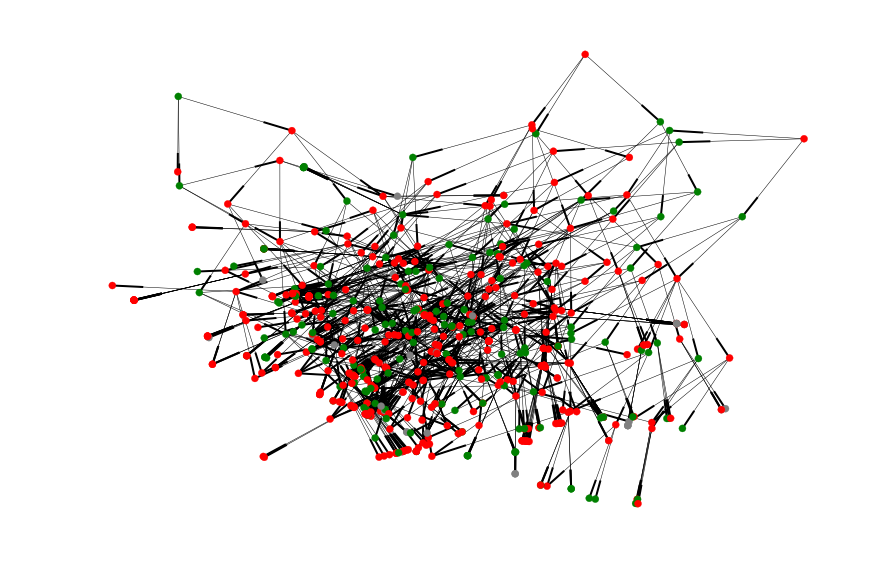

In [95]:
draw_graph(G_6, plt, print_pos=False, print_neg=False)

In [96]:
generate_user_submission(G_6, 6)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://adclick.g.doubleclick.net/aclk?sa=L&ai=BZxab-ojyVpK1OJaN3QHKmITADeOS354EAAAAEAEg94TLDTgAWPOWj5-LAWDJlu6IhKTsD7IBC29jdy5taXQuZWR1ugEJZ2ZwX2ltYWdlyAEJ2gETaHR0cDovL29jdy5taXQuZWR1L8ACAuACAOoCGS8xMDY0OTE3L0hPTUVfQ09SUF9MT0dPXzH4AoPSHpAD4AOYA-ADqAMB0ASQTuAEAdIFBRD7pq8VkAYBoAYW2AcA4AcL&num=0&cid=5GgU3FUiGrTUm6Pu6-Q-0kcG&sig=AOD64_0uHWl6tH9gNwZT5-9LEB7wl5vRbg&client=ca-pub-6588555046597237&adurl=http://www.academica.mx/' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2BO0Rv8&h=ATMOQ9dkfdA9Bh5eFAYFh4ZLJzTRjyKCJPaTlZsLqLIWYizrp4Sj35xt4AIOV1T-_gWI1tCII93t7drM9IXqTC10tn-zrkxveKrN7iFrNwnYvkLGFurchuqFiL2uAODGiSPs8KJ8CoHgEGCk3ILuWFJ3c2r7akrT7ScUOp9XYlQjT-4LKCjiErgWwRDvujQsape

Already seen platforms. Don't want to overfit so skip.

In [97]:
G_7 = BFS_on_next_fields(pipeline_5, field_iterator)

BFS on roots: [ 'https://www.shortcoursesportal.com/studies/37588/diploma-in-social-studies-and-counselling-skills-one-year-programme.html'
 'https://www.shortcoursesportal.com/studies/37588/diploma-in-social-studies-and-counselling-skills-one-year-programme.html'
 'http://www.dodea.edu/Curriculum/socialStudies/courses.cfm'
 'https://alex.state.al.us/browseSS.php'
 'http://www.shawsheentech.org/academics/socialstudiescoursedescriptions.html']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
......

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.shortcoursesportal.com%2Fstudies%2F37588%2Fdiploma-in-social-studies-and-counselling-skills-one-year-programme.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


...

Exception while parsing https://sl.prtl.co/track/click/?target=http%3A%2F%2Fwww.arlt-foundation.org%2Fdiplomacourse.html
'NoneType' object has no attribute 'findAll'


...............................

Exception while requesting mailto:Superintendent.Mediterranean.DSO@eu.dodea.edu
No connection adapters were found for 'mailto:Superintendent.Mediterranean.DSO@eu.dodea.edu'


................................

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.bachelorsportal.com%2Farticles%2F608%2Fwhat-can-i-become-with-a-bachelors-degree-in-economics.html%3Futm_source%3DFB_organic%26utm_medium%3DBachelors_degree_in_economics%26utm_campaign%3DFB_organic&h=ATNS7uigSYQLQtt7cf6R5vCJQaq40QqiGnGo_WbSVUvDJG8rJi9N5u14zoPmDww25-94uFPeeU4cyym5C5ysi87YXVPGK4qg-2Hx3mWUlV27Lyrrl4hVlMYSyX0hYJBzEytnXl7PoAqLsHhGUpCKETcC2pe-cECri4zX21092o8liwSsuQ9DMLYRtik_otAHAu3vnuqyOzRlX6Dig_N8X9bIs_I7Yd_mFaq-tF4Jpm9eqBj4Bdj8jN9uQ0TZZ6pdBFVa3Je_R6gHykKSiUyVdWkZX1A
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.bachelorsportal.com%2Farticles%2F608%2Fwhat-can-i-become-with-a-bachelors-degree-in-economics.html%3Futm_source%3DFB_organic%26utm_medium%3DBachelors_degree_in_economics%26utm_campaign%3DFB_organic&h=ATNS7uigSYQLQtt7cf6R5vCJQaq40QqiGnGo_WbSVUvDJG8rJi9N5u14zoPmDww25-94uFPeeU4cyym5C5ysi87YXVPGK4qg-2Hx3mWUlV27Lyrrl4hVlMYSyX0hYJBzEytn

..

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.bachelorsportal.com%2Farticles%2F636%2Fwhat-is-industrial-engineering-and-why-should-i-study-it.html%3Futm_source%3DFB_organic%26utm_medium%3DWhat_is_industrial_engineering%26utm_campaign%3DFB_organic&h=ATOH4WzYjRfndZANrehgBdAY5CbC5DSQwojp2ityP1IV6fS8-ix8rTGzzcQpaRW40RGyHnLvxlmaO2Qi0i21w5TD_zyhvBwbvN6xEePGfK7UrU86oSQE3Xce52RpHSQODKTvvgQLgxUwBfvv5_TnAAe4YoTgS1oxWRaKb_akK-fHXWEg_E6NCfN_ErEoUCt741cgYssumhFjmRyE8wpKlgP4PT410M14822sUvd34Mk-muaKtGcZBPy95GDDinH9RZzowzFrQe1leKePTD4MvS36_aw
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.bachelorsportal.com%2Farticles%2F636%2Fwhat-is-industrial-engineering-and-why-should-i-study-it.html%3Futm_source%3DFB_organic%26utm_medium%3DWhat_is_industrial_engineering%26utm_campaign%3DFB_organic&h=ATOH4WzYjRfndZANrehgBdAY5CbC5DSQwojp2ityP1IV6fS8-ix8rTGzzcQpaRW40RGyHnLvxlmaO2Qi0i21w5TD_zyhvBwbvN6xEePGfK7UrU86oSQE3Xce52RpHS

...

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.distancelearningportal.com%2Funiversities%2F242%2Funiversity-of-lincoln.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


.......

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.shortcoursesportal.com%2Funiversities%2F17843%2Fqueen-mary-university-of-london-summer-school.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


................

Exception while requesting mailto:KaiserslauternDSO.superintendent@eu.dodea.edu
No connection adapters were found for 'mailto:KaiserslauternDSO.superintendent@eu.dodea.edu'


.

Exception while requesting mailto:Supt.Korea.DSO@pac.dodea.edu
No connection adapters were found for 'mailto:Supt.Korea.DSO@pac.dodea.edu'


...

Exception while requesting mailto:KaiserslauternDSO.superintendent@eu.dodea.edu
No connection adapters were found for 'mailto:KaiserslauternDSO.superintendent@eu.dodea.edu'


.........

Exception while requesting mailto:Supt.Korea.DSO@pac.dodea.edu
No connection adapters were found for 'mailto:Supt.Korea.DSO@pac.dodea.edu'


.............

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.smore.com%2Fyf4x2-alex&h=ATNfMescimbcRT05HNNndW39Nvs5CRuBMUoeWxbPVKYGfRhRpYZ1Chsn15GaJG-_UvhxCZ4uorU7Fc8ESh4vZibqUpLDDAYR1SzdTYKt8xBOhEbRfHI3emUW-17cwAlazsnPx37PBxdiDGhLNBG_Tny2iHntsJCnkBUuLi0TG2hOVZaTKrMnWBBCPOAZHevjzagn86iNnvNms6hBsLdkDetixU7W99Pc-OOEgKveAI8GhcJPdd-GsVAZ14gUiE9HwMiPtkr_2ACGsiJDh99F9Og
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fwww.smore.com%2Fyf4x2-alex&h=ATNfMescimbcRT05HNNndW39Nvs5CRuBMUoeWxbPVKYGfRhRpYZ1Chsn15GaJG-_UvhxCZ4uorU7Fc8ESh4vZibqUpLDDAYR1SzdTYKt8xBOhEbRfHI3emUW-17cwAlazsnPx37PBxdiDGhLNBG_Tny2iHntsJCnkBUuLi0TG2hOVZaTKrMnWBBCPOAZHevjzagn86iNnvNms6hBsLdkDetixU7W99Pc-OOEgKveAI8GhcJPdd-GsVAZ14gUiE9HwMiPtkr_2ACGsiJDh99F9Og'


................................

Exception while requesting mailto:lscott@shawsheen.tec.ma.us
No connection adapters were found for 'mailto:lscott@shawsheen.tec.ma.us'


..........................................................................................

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.shortcoursesportal.com%2Fstudies%2F193841%2Fdelivering-a-data-warehouse-in-the-cloud.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


..........

Exception while requesting mailto:DoDEAAmericasSuptGA/AL@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptGA/AL@am.dodea.edu'


....

Exception while requesting mailto:DoDEAAmericasSuptNY/VA@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptNY/VA@am.dodea.edu'


.................................

Exception while requesting mailto:DoDEAAmericasSuptKY@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptKY@am.dodea.edu'


...

Exception while requesting mailto:OkinawaSupt_DSO@pac.dodea.edu
No connection adapters were found for 'mailto:OkinawaSupt_DSO@pac.dodea.edu'


..

Exception while requesting mailto:DoDEAAmericasSuptGA/AL@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptGA/AL@am.dodea.edu'


..

Exception while requesting mailto:Supt.Japan.DSO@pac.dodea.edu
No connection adapters were found for 'mailto:Supt.Japan.DSO@pac.dodea.edu'


.

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


.....

Exception while requesting javascript:;
No connection adapters were found for 'javascript:;'


....

Exception while requesting mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu'


....

Exception while requesting mailto:OkinawaSupt_DSO@pac.dodea.edu
No connection adapters were found for 'mailto:OkinawaSupt_DSO@pac.dodea.edu'


....................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2z7LWv5&h=ATNXZtuGGwSFf6P_FcsaYgEiQ7V0KL5WBxckqdtso9SaNs_AqdKcbi9cCv6dkhzO4OWb4VVUYjjOLFPncl7UQIR38exIdZbPr_58FhdyqKydGEXAMXqB6wPHNE9WjUdR4q9P096LHXDp1SSFEF-jcOO7ndhKExhBdoNMAwopLPPcGCaastgSijO4fOfjUjelqWL7L04rA5hWIuKcz8JeXKQdNUZB_GbPMdNseoLoyld6ClS_bgW3SXYFEhFf6zLbiWET7rabOMjZt3g2y941Tlg
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2z7LWv5&h=ATNXZtuGGwSFf6P_FcsaYgEiQ7V0KL5WBxckqdtso9SaNs_AqdKcbi9cCv6dkhzO4OWb4VVUYjjOLFPncl7UQIR38exIdZbPr_58FhdyqKydGEXAMXqB6wPHNE9WjUdR4q9P096LHXDp1SSFEF-jcOO7ndhKExhBdoNMAwopLPPcGCaastgSijO4fOfjUjelqWL7L04rA5hWIuKcz8JeXKQdNUZB_GbPMdNseoLoyld6ClS_bgW3SXYFEhFf6zLbiWET7rabOMjZt3g2y941Tlg'


............

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2B0Zol4&h=ATM9PwnbQmEDIdFe1qPH9mPxgce0gmk1v3eZZltpymzOs2tQy6H-1LorITVdaKMc_5Lc1BovfxYPXU66gClHAH5kdLOepqAI6GvgNHMOpOI8ronfYSBgAtCuxAS_a4jFlk7KL23k0mKuEKBQyUKgaspG_sgQdwKOVsgFPposyqmjrYqDqSc22D86IdOd0sHmXJmcDbFdBrjMm6E5PP8j3UZlojiNvKOeTkMce7WjBFpkqFK2EXPBP16cRk_QMm6q-QVjRfOJsIxgMa4BHFIu_9LOehM
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2B0Zol4&h=ATM9PwnbQmEDIdFe1qPH9mPxgce0gmk1v3eZZltpymzOs2tQy6H-1LorITVdaKMc_5Lc1BovfxYPXU66gClHAH5kdLOepqAI6GvgNHMOpOI8ronfYSBgAtCuxAS_a4jFlk7KL23k0mKuEKBQyUKgaspG_sgQdwKOVsgFPposyqmjrYqDqSc22D86IdOd0sHmXJmcDbFdBrjMm6E5PP8j3UZlojiNvKOeTkMce7WjBFpkqFK2EXPBP16cRk_QMm6q-QVjRfOJsIxgMa4BHFIu_9LOehM'


.

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2CFvTXs&h=ATPdZYxj2DyQm-5WxGW7-XxAvI3WhR6qPGuCP81uKQbvv3Yk6Tyxt1BKazbFK70UQxSBHf3qo2RicF1EUvc4qjg6IQ7xhx13DmXH5qzBcQQ_LQlBEf7EGaqkzJ82M5wjbVTQxwfaL2TrGCLV0vtwc2IefTxsUVY1qc-gh9yklTmNPbu686gXU19LSqtRoXofXTgWRwEHCrwsqUM4liFaEsNlf9qITKTvf7EV-4O7CZifsJ2uSYO5igsmGGURkagix3YD83q2bn1G6jvHghy4G2M46Ig
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2CFvTXs&h=ATPdZYxj2DyQm-5WxGW7-XxAvI3WhR6qPGuCP81uKQbvv3Yk6Tyxt1BKazbFK70UQxSBHf3qo2RicF1EUvc4qjg6IQ7xhx13DmXH5qzBcQQ_LQlBEf7EGaqkzJ82M5wjbVTQxwfaL2TrGCLV0vtwc2IefTxsUVY1qc-gh9yklTmNPbu686gXU19LSqtRoXofXTgWRwEHCrwsqUM4liFaEsNlf9qITKTvf7EV-4O7CZifsJ2uSYO5igsmGGURkagix3YD83q2bn1G6jvHghy4G2M46Ig'


.......

Exception while requesting javascript:history.back()
No connection adapters were found for 'javascript:history.back()'


......................................

Exception while requesting mailto:cjoudrey@shawsheen.tec.ma.us
No connection adapters were found for 'mailto:cjoudrey@shawsheen.tec.ma.us'


..

Exception while requesting mailto:jcerbone@shawsheen.tec.ma.us
No connection adapters were found for 'mailto:jcerbone@shawsheen.tec.ma.us'


.............................

Exception while parsing https://www.eventbrite.com/support/articleredirect?anum=3275
'NoneType' object has no attribute 'findAll'


.............

Exception while requesting javascript:EmbeddedPopup.popupManager.open('loginHelp.do?', 420, 320, 100)
No connection adapters were found for 'javascript:EmbeddedPopup.popupManager.open('loginHelp.do?', 420, 320, 100)'


................................................

Exception while parsing https://www.linkedin.com/company/393845
'NoneType' object has no attribute 'findAll'


..........

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.bachelorsportal.com%2Funiversities%2F14338%2Famerican-university-washington-dc-kogod-school-of-business.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


...

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.bachelorsportal.com%2Funiversities%2F1490%2Fecole-hateliare-de-lausanne.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


..............

Exception while parsing https://www.linkedin.com/company/393845
'NoneType' object has no attribute 'findAll'


............................................................................

Exception while requesting http://9nl.com/BritishCouncil_IELTS/?utm_source=StudyPortals.eu&utm_medium=https%3A%2F%2Fwww.distancelearningportal.com%2Funiversities%2F11807%2Fbritish-study-centres.html&utm_campaign=SP_text_ad
("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",)


..............................................

Exception while requesting mailto:students@studyportals.com
No connection adapters were found for 'mailto:students@studyportals.com'


..

Exception while requesting mailto:insights@studyportals.com?subject=Services Enquiry
No connection adapters were found for 'mailto:insights@studyportals.com?subject=Services Enquiry'


....................................................

Exception while requesting mailto:students@studyportals.com
No connection adapters were found for 'mailto:students@studyportals.com'


........................

Exception while requesting mailto:OkinawaSupt_DSO@pac.dodea.edu
No connection adapters were found for 'mailto:OkinawaSupt_DSO@pac.dodea.edu'


.

Exception while requesting mailto:DoDEAAmericasSuptLJ@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptLJ@am.dodea.edu'


.....

Exception while requesting https://help.ds.dodea.edu/support/
HTTPSConnectionPool(host='help.ds.dodea.edu', port=443): Max retries exceeded with url: /support/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fb1076ac048>: Failed to establish a new connection: [Errno -2] Name or service not known',))


..

Exception while requesting mailto:DoDEAAmericasSuptKY@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptKY@am.dodea.edu'


..

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


................................

Exception while requesting javascript:;
No connection adapters were found for 'javascript:;'


.......

Exception while requesting mailto:OkinawaSupt_DSO@pac.dodea.edu
No connection adapters were found for 'mailto:OkinawaSupt_DSO@pac.dodea.edu'


...

Exception while requesting http://slicclassic.dodea.edu/search~S195
HTTPConnectionPool(host='slicclassic.dodea.edu', port=80): Max retries exceeded with url: /search~S195 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fb0e7365550>: Failed to establish a new connection: [Errno 110] Connection timed out',))


.........

Exception while requesting mailto:OkinawaSupt_DSO@pac.dodea.edu
No connection adapters were found for 'mailto:OkinawaSupt_DSO@pac.dodea.edu'


..

Exception while requesting mailto:DoDEAAmericasSuptPR@am.dodea.edu 
No connection adapters were found for 'mailto:DoDEAAmericasSuptPR@am.dodea.edu '


..

Exception while requesting https://school.biz.dodea.edu/OKI/KDMS/teacher/
HTTPSConnectionPool(host='school.biz.dodea.edu', port=443): Max retries exceeded with url: /OKI/KDMS/teacher/ (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fb0d5b73b70>: Failed to establish a new connection: [Errno -2] Name or service not known',))


................

Exception while requesting mailto:Supt.Japan.DSO@pac.dodea.edu
No connection adapters were found for 'mailto:Supt.Japan.DSO@pac.dodea.edu'


...............

Exception while requesting mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu'


.

Exception while requesting mailto:DoDEAAmericasSuptBG/CU@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptBG/CU@am.dodea.edu'


.........

Exception while requesting mailto:Supt.Japan.DSO@pac.dodea.edu
No connection adapters were found for 'mailto:Supt.Japan.DSO@pac.dodea.edu'


....

Exception while requesting mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu
No connection adapters were found for 'mailto:DoDEAAmericasSuptSC/ST@am.dodea.edu'


............................

Exception while requesting mailto:IDSO.AssistantSup@eu.dodea.edu
No connection adapters were found for 'mailto:IDSO.AssistantSup@eu.dodea.edu'


.........................................................................

Exception while requesting javascript:history.back()
No connection adapters were found for 'javascript:history.back()'


................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2FEconEdLink.org%2F&h=ATPPAkuy3SYZ6iveSGMlDrSs08TdHLN3PVWMm_V4HwH8gRsrM31ElIvSey9q9jqD2UXrlai11JA4mudHNqqJlZ9DrBTGGgBdzcawy26AjpgWDZGmenS5AOynMsCB9EEQ-uUiQHTOoRAZ1V_28mMRyma3FU-LMJtOfy2l6NLaI-yoUEBB87y5qbIlBLzqWp3bpEMxAf58a7lOUP5XlwJWf07rvuVaBoc1GrjMZE-EXTZG1vT5lEzgnYxP768_Zn3YUYD3AypfA_NJeOiog4NVLKPcSQ8
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2FEconEdLink.org%2F&h=ATPPAkuy3SYZ6iveSGMlDrSs08TdHLN3PVWMm_V4HwH8gRsrM31ElIvSey9q9jqD2UXrlai11JA4mudHNqqJlZ9DrBTGGgBdzcawy26AjpgWDZGmenS5AOynMsCB9EEQ-uUiQHTOoRAZ1V_28mMRyma3FU-LMJtOfy2l6NLaI-yoUEBB87y5qbIlBLzqWp3bpEMxAf58a7lOUP5XlwJWf07rvuVaBoc1GrjMZE-EXTZG1vT5lEzgnYxP768_Zn3YUYD3AypfA_NJeOiog4NVLKPcSQ8'


.

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fwww.councilforeconed.org%2Fevents%2Ffinancial-literacy-month%2F&h=ATMbPRKyKR69e5HWI5d58CbTQ13fTMTizUJomCdm27ws7e4N6uSMoOJsD-PCAV9fKf4tPKNehCtMLf7F_uPwX4dPmsSyINrSva9f-Hb-lz_VcsAQpm4DwxjfHxWPkRdCl5jAUYhEW3LDsn7jmDs9bARvTqai03uioJvzh-ISQACOO21oCfOyzt-Oxd4k1ceRwXR39OMCH9hBW3mkfPX3NiEGl3kpq6Zgz7gZTnsqbg8rz5_nUHmpn4OzA4iUGMuOQ7wvNGe6Dq4-4SjfQKUZ
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fwww.councilforeconed.org%2Fevents%2Ffinancial-literacy-month%2F&h=ATMbPRKyKR69e5HWI5d58CbTQ13fTMTizUJomCdm27ws7e4N6uSMoOJsD-PCAV9fKf4tPKNehCtMLf7F_uPwX4dPmsSyINrSva9f-Hb-lz_VcsAQpm4DwxjfHxWPkRdCl5jAUYhEW3LDsn7jmDs9bARvTqai03uioJvzh-ISQACOO21oCfOyzt-Oxd4k1ceRwXR39OMCH9hBW3mkfPX3NiEGl3kpq6Zgz7gZTnsqbg8rz5_nUHmpn4OzA4iUGMuOQ7wvNGe6Dq4-4SjfQKUZ'


............

Exception while requesting javascript:history.back()
No connection adapters were found for 'javascript:history.back()'


...

Exception while requesting javascript:dropdowncontent.hidediv('tflacsubcontent0c9b0fcf-6a88-4e48-b241-ad47e452311e')
No connection adapters were found for 'javascript:dropdowncontent.hidediv('tflacsubcontent0c9b0fcf-6a88-4e48-b241-ad47e452311e')'


............................................................................................

Exception while requesting mailto:tromkey@shawsheen.tec.ma.us
No connection adapters were found for 'mailto:tromkey@shawsheen.tec.ma.us'


.

Exception while requesting mailto:aouellette@shawsheen.tec.ma.us
No connection adapters were found for 'mailto:aouellette@shawsheen.tec.ma.us'


...................................

Exception while requesting javascript:EmbeddedPopup.popupManager.open('passwordRecovery.do?isSecondary=false&deploymentId=ma-shawsheentech', 400, 400, 100)
No connection adapters were found for 'javascript:EmbeddedPopup.popupManager.open('passwordRecovery.do?isSecondary=false&deploymentId=ma-shawsheentech', 400, 400, 100)'


..........................................

Exception while parsing https://www.eventbrite.com/tos
'NoneType' object has no attribute 'findAll'


.....

Exception while requesting javascript://
No connection adapters were found for 'javascript://'


..........................

Exception while requesting mailto:customerservice@follett.com?subject=I%20have%20a%20question
No connection adapters were found for 'mailto:customerservice@follett.com?subject=I%20have%20a%20question'


.Crawling finished after 1758.280354499817s


In [99]:
nx.write_gpickle(G_7, os.path.join('saved', 'graphs', 'G_7.pickle'))

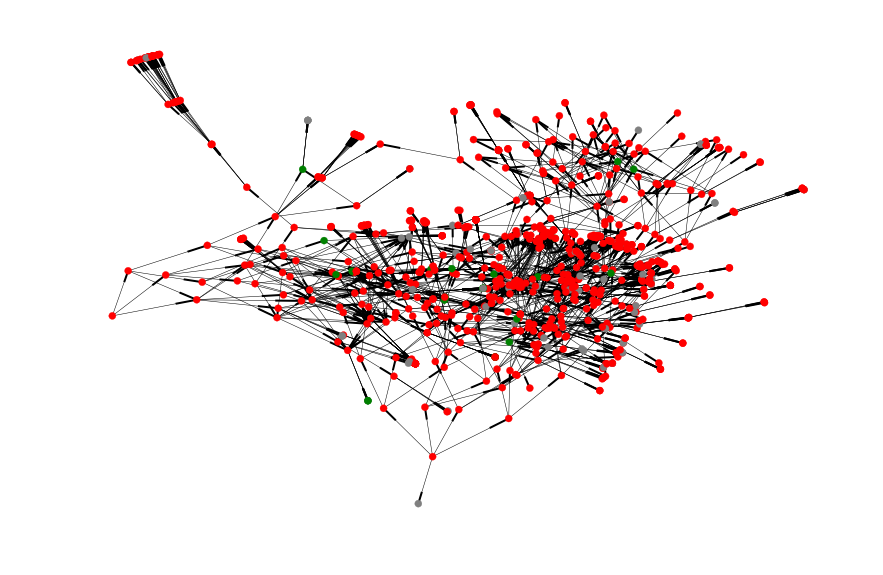

In [98]:
draw_graph(G_7, plt, print_pos=False, print_neg=False)

In [100]:
generate_user_submission(G_7, 7)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://twitter.com/home?status=Advancing%20Your%20Higher%20Education%20During%20Your%20Vacation%20–%20Summer%20and%20Winter%20Courses%20https://www.shortcoursesportal.com/articles/317/advancing-your-higher-education-during-your-vacation-a-summer-and-winter-courses.html' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2CFvTXs&h=ATPdZYxj2DyQm-5WxGW7-XxAvI3WhR6qPGuCP81uKQbvv3Yk6Tyxt1BKazbFK70UQxSBHf3qo2RicF1EUvc4qjg6IQ7xhx13DmXH5qzBcQQ_LQlBEf7EGaqkzJ82M5wjbVTQxwfaL2TrGCLV0vtwc2IefTxsUVY1qc-gh9yklTmNPbu686gXU19LSqtRoXofXTgWRwEHCrwsqUM4liFaEsNlf9qITKTvf7EV-4O7CZifsJ2uSYO5igsmGGURkagix3YD83q2bn1G6jvHghy4G2M46Ig' with link or location/anchor > 255 characters since it exceeds E

The new platforms were not online platforms (links to school degrees)

In [101]:
G_8 = BFS_on_next_fields(pipeline_5, field_iterator)

BFS on roots: ['https://www.topuniversities.com/courses/geography/guide'
 'https://www.coursera.org/courses?languages=en&query=geography'
 'https://geography.osu.edu/courses'
 'https://www.coursera.org/courses?languages=en&query=geography'
 'https://geography.as.uky.edu/geography-current-course-list']

BFS started with params: 
Depth_limit: 5
Breadth_limit: 3.
Estimated time: 3645s
....................................................................................................

Exception while parsing https://www.linkedin.com/company/coursera
'NoneType' object has no attribute 'findAll'


....................................................................

Exception while requesting mailto:?subject=French Studies Forum on the Paris Attacks  - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fgeography.as.uky.edu%2Fpodcasts%2Ffrench-studies-forum-paris-attacks
No connection adapters were found for 'mailto:?subject=French Studies Forum on the Paris Attacks  - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fgeography.as.uky.edu%2Fpodcasts%2Ffrench-studies-forum-paris-attacks'


................................................................................................................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATNhDWxzdp22WzUUiXhHsyFCZxPub0JQz3aEeUVEzGm4Go4BB4TR8ijLeqj21JlvcrSeMzlY-F5WL7FGQEfepFx8n79qM5XYBhLBBCPmWyjpRQNgJBTr6Tq4k9hIiCYvQX8hHl3fC6TTruwuL9WiGqhc9jXAtspfJrQindnOKZF2x4dtPVEYX9yf3hf-w6uZCfEbPRpIcmUlyBmXwLvN5UOSZhyZHNcZV7xn-X33VxRi9DrY_DxHEfiulGZINGg38M6p0Ntecn-4Qec5eEIh0M330ZM
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fbit.ly%2F2iV9We7&h=ATNhDWxzdp22WzUUiXhHsyFCZxPub0JQz3aEeUVEzGm4Go4BB4TR8ijLeqj21JlvcrSeMzlY-F5WL7FGQEfepFx8n79qM5XYBhLBBCPmWyjpRQNgJBTr6Tq4k9hIiCYvQX8hHl3fC6TTruwuL9WiGqhc9jXAtspfJrQindnOKZF2x4dtPVEYX9yf3hf-w6uZCfEbPRpIcmUlyBmXwLvN5UOSZhyZHNcZV7xn-X33VxRi9DrY_DxHEfiulGZINGg38M6p0Ntecn-4Qec5eEIh0M330ZM'


.........................................................................................................................

Exception while requesting http://t.umblr.com/redirect?z=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DB9rVRgrE6YU&t=NTJlODk5NDZiYWExOWFkY2ZhYTYzODk1ZTU0ZmZlNGQ2MDZkYWM3Myw0dGUyVDd2Tw%3D%3D&b=t%3AqatNCUur3Z2NmRhps5KmRg&p=http%3A%2F%2Fcoursera.tumblr.com%2Fpost%2F155768527042%2Finfographic-united-states-of-knowledge&m=1
[Errno 36] File name too long: 'webpages/experiment1/cache/http:,,t.umblr.com,redirect?z=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DB9rVRgrE6YU&t=NTJlODk5NDZiYWExOWFkY2ZhYTYzODk1ZTU0ZmZlNGQ2MDZkYWM3Myw0dGUyVDd2Tw%3D%3D&b=t%3AqatNCUur3Z2NmRhps5KmRg&p=http%3A%2F%2Fcoursera.tumblr.com%2Fpost%2F155768527042%2Finfographic-united-states-of-knowledge&m=1'


..

Exception while requesting http://t.umblr.com/redirect?z=https%3A%2F%2Fwww.coursera.org%2Fspecializations%2Fbig-data&t=YWE1MmQ5ZjIwNDY1YTkwNDU0NTgwN2Y1NmU5Nzg4Njc3Y2ZmYTJhNCxXZVdoT1pxSg%3D%3D&b=t%3AqatNCUur3Z2NmRhps5KmRg&p=http%3A%2F%2Fcoursera.tumblr.com%2Fpost%2F154812914287%2Fthe-most-popular-courses-of-2016&m=1
[Errno 36] File name too long: 'webpages/experiment1/cache/http:,,t.umblr.com,redirect?z=https%3A%2F%2Fwww.coursera.org%2Fspecializations%2Fbig-data&t=YWE1MmQ5ZjIwNDY1YTkwNDU0NTgwN2Y1NmU5Nzg4Njc3Y2ZmYTJhNCxXZVdoT1pxSg%3D%3D&b=t%3AqatNCUur3Z2NmRhps5KmRg&p=http%3A%2F%2Fcoursera.tumblr.com%2Fpost%2F154812914287%2Fthe-most-popular-courses-of-2016&m=1'


.........................................................................................

Exception while requesting https://twitter.com/intent/tweet?url=https%3A%2F%2Fgeography.as.uky.edu%2Fcontinuation-uk%25E2%2580%2599s-legacy-mexico-harrison-and-eva-lewis-bailey-geography-student-travel-endowment&text=A+Continuation+of+UK%E2%80%99s+Legacy+in+Mexico%3A+The+Harrison+and+Eva+Lewis+Bailey+Geography+Student+Travel+Endowment+Fund
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,twitter.com,intent,tweet?url=https%3A%2F%2Fgeography.as.uky.edu%2Fcontinuation-uk%25E2%2580%2599s-legacy-mexico-harrison-and-eva-lewis-bailey-geography-student-travel-endowment&text=A+Continuation+of+UK%E2%80%99s+Legacy+in+Mexico%3A+The+Harrison+and+Eva+Lewis+Bailey+Geography+Student+Travel+Endowment+Fund'


.........

Exception while requesting mailto:?subject=Proctoring for Exams in Online Courses - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fstudents.as.uky.edu%2Fproctoring
No connection adapters were found for 'mailto:?subject=Proctoring for Exams in Online Courses - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fstudents.as.uky.edu%2Fproctoring'


.................................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


........................................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


........................................................................................

Exception while requesting javascript:void(0)
No connection adapters were found for 'javascript:void(0)'


....................

Exception while requesting https://es-la.facebook.com/login.php?skip_api_login=1&api_key=1398671143732490&signed_next=1&next=https%3A%2F%2Fwww.facebook.com%2Fv2.5%2Fdialog%2Foauth%3Fredirect_uri%3Dhttps%253A%252F%252Fwww.topuniversities.com%252Fuser%252Fsimple-fb-connect%252Freturn%26state%3Dd48eab83ae48b5aeb3a0af778c116cb8%26scope%3Dpublic_profile%252Cemail%26client_id%3D1398671143732490%26ret%3Dlogin%26sdk%3Dphp-sdk-4.0.23%26logger_id%3D4f959e21-0eab-0ffc-1c29-b91f647b64d5&cancel_url=https%3A%2F%2Fwww.topuniversities.com%2Fuser%2Fsimple-fb-connect%2Freturn%3Ferror%3Daccess_denied%26error_code%3D200%26error_description%3DPermissions%2Berror%26error_reason%3Duser_denied%26state%3Dd48eab83ae48b5aeb3a0af778c116cb8%23_%3D_&display=page&locale=es_LA&logger_id=4f959e21-0eab-0ffc-1c29-b91f647b64d5
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,es-la.facebook.com,login.php?skip_api_login=1&api_key=1398671143732490&signed_next=1&next=https%3A%2F%2Fwww.facebook.com%2Fv2.5%2F

.....

Exception while requesting javascript:void(0);
No connection adapters were found for 'javascript:void(0);'


.............................................

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fon.wsj.com%2F2qyfTnU&h=ATN28pjeN-1euV4RcPR4dqq4b3pAp4vbYcDxY4tZ5Qzsh_65f8ChWC3gwkCKCHNxIalxapXJwR0XGgtmdms1qYq_XW78wA26LBWjdvOhQj8sQNqIFeHiJTm1VjJB1DBSPZ-LuIhyKoYrSEU2AZ9QJjgV21Xt3m492MmHtzZ59uJxtFwoo12mfjiFJDlJnfX3iEI8L0b7nwjnMbtR1ds3Bo1zxKwbIaBpFigksD8Hc3C8nqZIpMaPBepPxQS3m4BxXCu3q02ZmdHE2A4mQrwyyg
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fon.wsj.com%2F2qyfTnU&h=ATN28pjeN-1euV4RcPR4dqq4b3pAp4vbYcDxY4tZ5Qzsh_65f8ChWC3gwkCKCHNxIalxapXJwR0XGgtmdms1qYq_XW78wA26LBWjdvOhQj8sQNqIFeHiJTm1VjJB1DBSPZ-LuIhyKoYrSEU2AZ9QJjgV21Xt3m492MmHtzZ59uJxtFwoo12mfjiFJDlJnfX3iEI8L0b7nwjnMbtR1ds3Bo1zxKwbIaBpFigksD8Hc3C8nqZIpMaPBepPxQS3m4BxXCu3q02ZmdHE2A4mQrwyyg'


.

Exception while requesting https://l.facebook.com/l.php?u=http%3A%2F%2Fon.wsj.com%2F2AwBOvD&h=ATOAFn_FXlV1bMcywipfa1lsGye4Ockxak-OIXD2tnJynA7Se2NVP_6F2Qs5QLSFH2Ei0A9ayYU3BSqSitOBYNUxEKUJnUZ3PszLtkjqkDxHbGfa8L40ewOQaNepwCUlCljngK-54TET1_7f2xdPEMHpkGH1xC7QoQdlTXcymOcPI_DxaEHfusVwKzjJLkQCYPmIS9K8GeQMpg3IKjK8PPdxKBzur9twaO5vN9HYvUWwBHpUdqzaY_mZBllXonwPN4b2b0OdlkkyX73RLolH3Q
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=http%3A%2F%2Fon.wsj.com%2F2AwBOvD&h=ATOAFn_FXlV1bMcywipfa1lsGye4Ockxak-OIXD2tnJynA7Se2NVP_6F2Qs5QLSFH2Ei0A9ayYU3BSqSitOBYNUxEKUJnUZ3PszLtkjqkDxHbGfa8L40ewOQaNepwCUlCljngK-54TET1_7f2xdPEMHpkGH1xC7QoQdlTXcymOcPI_DxaEHfusVwKzjJLkQCYPmIS9K8GeQMpg3IKjK8PPdxKBzur9twaO5vN9HYvUWwBHpUdqzaY_mZBllXonwPN4b2b0OdlkkyX73RLolH3Q'


....................................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


......

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


.................

Exception while requesting https://l.facebook.com/l.php?u=https%3A%2F%2Fcloud.google.com%2Fblog%2Fbig-data%2F2017%2F11%2Fgoogle-cloud-provides-a-unified-streamlined-way-to-execute-your-ml-strategy&h=ATN06x6ER8raAvZvWUg7XryjMITpcPawoGXtWVxNyI4A9AtiegIkVScEnRHdRM8CP4_a2fWkHdX430YKqHDoLHuJPeDAG9CjOoiOsrUnypngZmAuUepTQAuslue6oOrWEhctGG1IuwNogSjyoGrZAigIO4_F0_BWPEtsbv8kufK8kRUCnQX6qy1ITaFjn_zKoOVV56GFLe_vaFwC5l_Y_WbTnMrY9r7Zbga9-lWyBDoGXDgMY3RLFZAUMcaPmOdEGnq-QJxueWFR65Gcdu_WV2VCnrA
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,l.facebook.com,l.php?u=https%3A%2F%2Fcloud.google.com%2Fblog%2Fbig-data%2F2017%2F11%2Fgoogle-cloud-provides-a-unified-streamlined-way-to-execute-your-ml-strategy&h=ATN06x6ER8raAvZvWUg7XryjMITpcPawoGXtWVxNyI4A9AtiegIkVScEnRHdRM8CP4_a2fWkHdX430YKqHDoLHuJPeDAG9CjOoiOsrUnypngZmAuUepTQAuslue6oOrWEhctGG1IuwNogSjyoGrZAigIO4_F0_BWPEtsbv8kufK8kRUCnQX6qy1ITaFjn_zKoOVV56GFLe_vaFwC5l_Y_WbTnMrY9r7Zbga9-lWyBDoGXDgMY3RLFZAUMcaPmOdEGnq-QJxueWFR65Gcdu_WV2VCnrA'


............

Exception while requesting https://twitter.com/intent/tweet?text=Meet%20the%20Courserians%3A%20Siong%20Chan%2C%20%E2%80%98There%20is%20no%20right%20answer%20in%20product%20design%E2%80%9D&url=https%3A%2F%2Fblog.coursera.org%2Fmeet-courserians-siong-chan-no-right-answer-product-design%2F&via=coursera
[Errno 36] File name too long: 'webpages/experiment1/cache/https:,,twitter.com,intent,tweet?text=Meet%20the%20Courserians%3A%20Siong%20Chan%2C%20%E2%80%98There%20is%20no%20right%20answer%20in%20product%20design%E2%80%9D&url=https%3A%2F%2Fblog.coursera.org%2Fmeet-courserians-siong-chan-no-right-answer-product-design%2F&via=coursera'


.

Exception while requesting mailto:?subject=Check out this Coursera post: &body=I thought you might be interested in this post from Coursera: https://blog.coursera.org/meet-courserians-siong-chan-no-right-answer-product-design/
No connection adapters were found for 'mailto:?subject=Check out this Coursera post: &body=I thought you might be interested in this post from Coursera: https://blog.coursera.org/meet-courserians-siong-chan-no-right-answer-product-design/'


..............................................................................................................

Exception while requesting mailto:okelly.1@osu.edu
No connection adapters were found for 'mailto:okelly.1@osu.edu'


.............................................................

Exception while requesting tel:614-292-2141
No connection adapters were found for 'tel:614-292-2141'


.......................................................................................................................................................................................................................

Exception while requesting javascript:console.log('chat started');
No connection adapters were found for 'javascript:console.log('chat started');'


...............................................................................................................................................................................

Exception while requesting mailto:webmaster@ukcc.uky.edu
No connection adapters were found for 'mailto:webmaster@ukcc.uky.edu'


................................

Exception while requesting mailto:?subject=Fall Courses - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fwww.as.uky.edu%2Ffall
No connection adapters were found for 'mailto:?subject=Fall Courses - College of Arts %26 Sciences%2C University of Kentucky&body=https%3A%2F%2Fwww.as.uky.edu%2Ffall'


...................

Exception while parsing https://www.uky.edu/GiveNow/index.php?select=AS
'NoneType' object has no attribute 'findAll'


.......................Crawling finished after 2475.56015086174s


In [104]:
nx.write_gpickle(G_8, os.path.join('saved', 'graphs', 'G_8.pickle'))

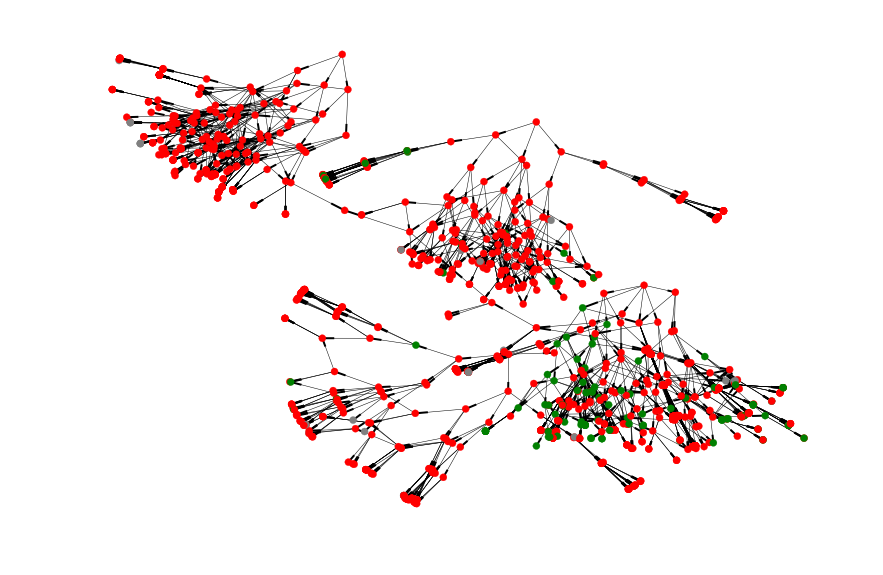

In [105]:
draw_graph(G_8, plt, print_pos=False, print_neg=False)

In [106]:
generate_user_submission(G_8, 8)

/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'https://l.facebook.com/l.php?u=http%3A%2F%2Fon.wsj.com%2F2qyfTnU&h=ATN28pjeN-1euV4RcPR4dqq4b3pAp4vbYcDxY4tZ5Qzsh_65f8ChWC3gwkCKCHNxIalxapXJwR0XGgtmdms1qYq_XW78wA26LBWjdvOhQj8sQNqIFeHiJTm1VjJB1DBSPZ-LuIhyKoYrSEU2AZ9QJjgV21Xt3m492MmHtzZ59uJxtFwoo12mfjiFJDlJnfX3iEI8L0b7nwjnMbtR1ds3Bo1zxKwbIaBpFigksD8Hc3C8nqZIpMaPBepPxQS3m4BxXCu3q02ZmdHE2A4mQrwyyg' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
/home/tim/anaconda3/lib/python3.5/site-packages/xlsxwriter/worksheet.py:829: UserWarning: Ignoring URL 'http://t.umblr.com/redirect?z=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DB9rVRgrE6YU&t=NTJlODk5NDZiYWExOWFkY2ZhYTYzODk1ZTU0ZmZlNGQ2MDZkYWM3Myw0dGUyVDd2Tw%3D%3D&b=t%3AqatNCUur3Z2NmRhps5KmRg&p=http%3A%2F%2Fcoursera.tumblr.com%2Fpost%2F155768527042%2Finfographic-united-states-of-knowledge&m=1' with link or location/anchor > 255 character

Again, not online courses or already seen platforms :'(

In [103]:
joblib.dump(pipeline_initial, os.path.join('saved', 'models', 'experiment1-pipeline_initial.pkl'))
joblib.dump(pipeline_1, os.path.join('saved', 'models', 'experiment1-pipeline_1.pkl'))
joblib.dump(pipeline_2, os.path.join('saved', 'models', 'experiment1-pipeline_2.pkl'))
joblib.dump(pipeline_4, os.path.join('saved', 'models', 'experiment1-pipeline_4.pkl'))
joblib.dump(pipeline_5, os.path.join('saved', 'models', 'experiment1-pipeline_5.pkl'))

['saved/models/experiment1-pipeline_5.pkl']

In [159]:
day_accuracies = [
    (0.724, 0.611),
    (0.735, 0.653),
    (0.735, 0.695),
    ('same', 'same'),
    (0.714, 0.695),
    ('same', 'same'),
    ('same', 'same'),
]

In [160]:
import matplotlib.patches as mpatches

/home/tim/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


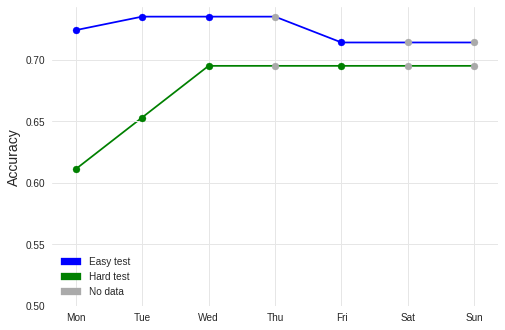

In [166]:
date = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
x = np.arange(7)
plt.xticks(x, date)


accuracies_easy = np.array([0.724, 0.735, 0.735, 0.735, 0.714, 0.714, 0.714])
accuracies_hard = np.array([0.611, 0.653, 0.695, 0.695, 0.695, 0.695, 0.695])

#Nan
failed = np.array([False, False, False, True, False, True, True])

plt.plot(x, accuracies_easy, c='blue', zorder=-1)
plt.plot(x, accuracies_hard, c='green', zorder=-1)

grey = '#AAAAAA'

plt.scatter(x[~failed], accuracies_easy[~failed], c='blue')
plt.scatter(x[failed], accuracies_easy[failed], c=grey)

plt.scatter(x[~failed], accuracies_hard[~failed], c='green')
plt.scatter(x[failed], accuracies_hard[failed], c=grey)

plt.ylim(ymin=0.5)

easy_patch = mpatches.Patch(color='blue', label='Easy test')
hard_patch = mpatches.Patch(color='green', label='Hard test')
nan_patch = mpatches.Patch(color=grey, label='No data')

plt.ylabel("Accuracy", fontsize=14)

plt.legend(handles=[easy_patch, hard_patch, nan_patch])

plt.legend()

ax = plt.gca()
ax.set_facecolor('white')
ax.grid(color=(0.9, 0.9, 0.9))

plt.savefig(os.path.join('figures', 'easy_hard_improvement'))
